# Predição de dose semanal para regulação de INR no uso da Vafarina

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import joblib
import xgboost as xgb
import lightgbm as lgb
import optuna
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from models.data_manipulator import INRDataManipulation
import warnings
warnings.filterwarnings("ignore")

## 1. Importação e tratamento dos dados

In [91]:
path1 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ADRIANA RAMOS PESSOA.xlsx"
path2 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALCIDES DE CARVALHO GALVAO.xlsx"
path3 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALEXANDRE JOSE MARTINS BORBOREMA2.xlsx"
path4 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALINE GOMES DE FREITAS RICARDO.xlsx"

In [92]:
data1 = pd.read_excel(path1, sheet_name="TTR")
data2 = pd.read_excel(path2, sheet_name="TTR")
data3 = pd.read_excel(path3, sheet_name="TTR")
data4 = pd.read_excel(path4, sheet_name="TTR")
display(data1.head())
display(data2.head())
display(data3.head())
display(data4.head())

,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,0.0,2022-10-10,1.21,NaN,,NaN,Below,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.000000
1,20.0,2022-10-18,1.43,8.0,0.22,Below,Below,Below,0.0,0.0,0.22,0.0,0.0,NaN,High Range,3.000000
2,22.5,2022-10-25,1.58,7.0,0.15,Below,Below,Below,0.0,0.0,0.15,0.0,0.0,NaN,NaN,NaN
3,25.0,2022-11-01,1.50,7.0,-0.08,Below,Below,Below,0.0,0.0,0.08,0.0,0.0,NaN,Rosendaal Method,NaN
4,27.5,2022-11-22,1.75,21.0,0.25,Below,Below,Below,0.0,0.0,0.25,0.0,0.0,NaN,Days Within Range,118668.038839


,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,35 MG,2025-03-18,4.84,NaN,,NaN,Above,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.500000
1,32.5,2025-03-25,2.35,7.0,-2.49,Above,Below,Calculate,1.34,1.00,0.15,2.811245,0.401606,NaN,High Range,3.500000
2,32.5,2025-04-08,3.93,14.0,1.58,Below,Above,Calculate,0.43,1.00,0.15,8.860759,0.632911,NaN,NaN,NaN
3,30,2025-04-15,3.03,7.0,-0.9,Above,In Range,Calculate,0.43,0.47,0.00,3.655556,0.522222,NaN,Rosendaal Method,NaN
4,30,2025-04-29,2.48,14.0,-0.55,In Range,Below,Calculate,0.00,0.53,0.02,13.490909,0.963636,NaN,Days Within Range,30.173308


,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,90.0,2022-07-27,2.94,NaN,,NaN,In Range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.500000
1,97.5,2022-08-02,2.84,6.0,-0.1,In Range,In Range,In Range,0.0,0.10,0.0,6.0,1.0,NaN,High Range,3.500000
2,97.5,2022-08-16,2.93,14.0,0.09,In Range,In Range,In Range,0.0,0.09,0.0,14.0,1.0,NaN,NaN,NaN
3,97.5,2022-09-13,3.26,28.0,0.33,In Range,In Range,In Range,0.0,0.33,0.0,28.0,1.0,NaN,Rosendaal Method,NaN
4,97.5,2022-10-04,3.44,21.0,0.18,In Range,In Range,In Range,0.0,0.18,0.0,21.0,1.0,NaN,Days Within Range,160220.710108


,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,95.0,2022-08-16,2.75,NaN,,NaN,In Range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.50000
1,95.0,2022-08-23,2.09,7.0,-0.66,In Range,Below,Calculate,0.0,0.25,0.41,2.651515,0.378788,NaN,High Range,3.50000
2,95.0,2022-08-26,2.96,3.0,0.87,Below,In Range,Calculate,0.0,0.46,0.41,1.586207,0.528736,NaN,NaN,NaN
3,95.0,2022-09-20,2.42,25.0,-0.54,In Range,Below,Calculate,0.0,0.46,0.08,21.296296,0.851852,NaN,Rosendaal Method,NaN
4,95.0,2022-10-04,2.02,14.0,-0.4,Below,Below,Below,0.0,0.00,0.40,0.000000,0.000000,NaN,Days Within Range,673.87535


### 1.1 Demonstração de tratamento básico

In [93]:
data4['low_range'] = data4.loc[0]['Unnamed: 15']
data4['high_range'] = data4.loc[1]['Unnamed: 15']

data_filtred = data4[['DOSE SEMANAL', 'Test Date', 'INR', 'INR Diff', 'low_range', 'high_range']].copy()
data_filtred = data_filtred.rename(columns={'DOSE SEMANAL': 'dose_semanal', 'INR Diff': 'inr_diff', 'INR': 'inr', 'Test Date': 'test_date'})

data_filtred["inr_diff"] = pd.to_numeric(data_filtred["inr_diff"], errors="coerce")

media_inr = data_filtred["inr"].mean()      
data_filtred["inr"] = data_filtred["inr"].fillna(media_inr)

data_filtred['inr_diff'] = data_filtred['inr'].diff().round(2)
data_filtred.loc[0, 'inr_diff'] = 0.00

display(data_filtred)
print(data_filtred.info())

,dose_semanal,test_date,inr,inr_diff,low_range,high_range
0,95.0,2022-08-16,2.750,0.00,2.5,3.5
1,95.0,2022-08-23,2.090,-0.66,2.5,3.5
2,95.0,2022-08-26,2.960,0.87,2.5,3.5
3,95.0,2022-09-20,2.420,-0.54,2.5,3.5
4,95.0,2022-10-04,2.020,-0.40,2.5,3.5
5,100.0,2022-10-18,2.430,0.41,2.5,3.5
6,100.0,2022-10-25,2.610,0.18,2.5,3.5
7,100.0,2022-11-08,2.670,0.06,2.5,3.5
8,100.0,2022-12-13,3.290,0.62,2.5,3.5
9,100.0,2022-12-20,2.640,-0.65,2.5,3.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dose_semanal  29 non-null     float64       
 1   test_date     29 non-null     datetime64[ns]
 2   inr           29 non-null     float64       
 3   inr_diff      29 non-null     float64       
 4   low_range     29 non-null     float64       
 5   high_range    29 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.5 KB
None


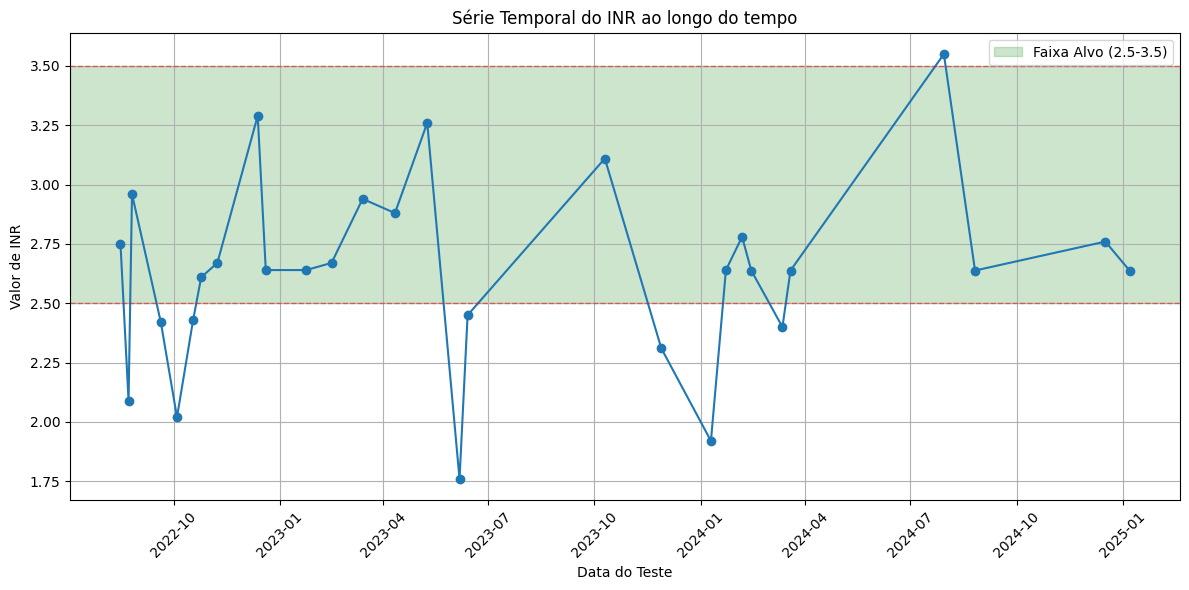

In [94]:
plt.figure(figsize=(12,6))
plt.plot(data_filtred['test_date'], data_filtred['inr'], marker='o')

plt.axhspan(2.5, 3.5, alpha=0.2, color='green', label='Faixa Alvo (2.5-3.5)')
plt.axhline(y=2.5, color='red', linestyle='--', alpha=0.5, linewidth=1)
plt.axhline(y=3.5, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel("Data do Teste")
plt.ylabel("Valor de INR")
plt.title("Série Temporal do INR ao longo do tempo")
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 1.2 Formulação e utilização de classe para tratamento padronizado dos dados

In [95]:
paciente1 = INRDataManipulation(path=path1)
paciente2 = INRDataManipulation(path=path2)
paciente3 = INRDataManipulation(path=path3)
paciente4 = INRDataManipulation(path=path4)
data1 = paciente1.get_data()
data2 = paciente2.get_data()
data3 = paciente3.get_data()
data4 = paciente4.get_data()
display(data4)
print(data4.info())

,test_date,dose_semanal,inr,inr_diff,low_range,high_range,generated
0,2022-08-16,95.0,2.750,0.000,2.5,3.5,False
1,2022-08-23,95.0,2.090,-0.660,2.5,3.5,False
2,2022-08-30,95.0,2.874,0.784,2.5,3.5,True
3,2022-09-06,95.0,2.722,-0.151,2.5,3.5,True
4,2022-09-13,95.0,2.571,-0.151,2.5,3.5,True
...,...,...,...,...,...,...,...
121,2024-12-10,100.0,2.752,0.008,2.5,3.5,True
122,2024-12-17,100.0,2.760,0.008,2.5,3.5,False
123,2024-12-24,100.0,2.719,-0.041,2.5,3.5,True
124,2024-12-31,100.0,2.679,-0.041,2.5,3.5,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   test_date     126 non-null    datetime64[ns]
 1   dose_semanal  126 non-null    float64       
 2   inr           126 non-null    float64       
 3   inr_diff      126 non-null    float64       
 4   low_range     126 non-null    float64       
 5   high_range    126 non-null    float64       
 6   generated     126 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(5)
memory usage: 6.2 KB
None


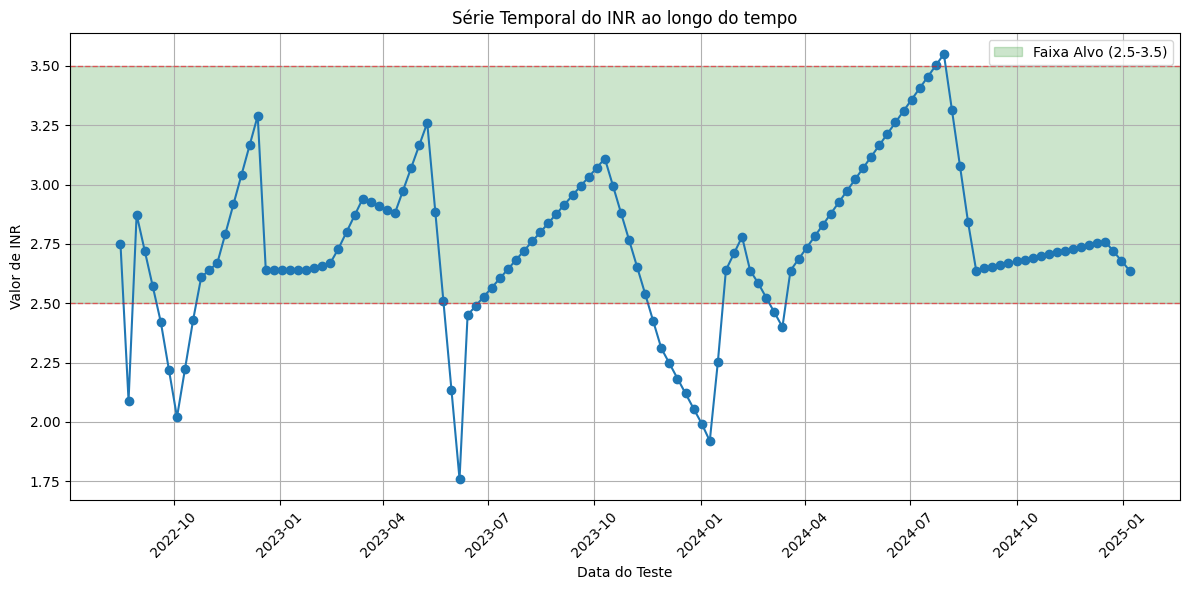

In [96]:
paciente4.plot_inr()

### 1.3 Criação de features e variáveis para a predição

In [97]:
def create_time_features(data, date_col="test_date", target_col="inr",
                         lags=[1,2,3,4], roll_windows=[2,4], add_generated_flag=True):
    df = data.copy()

    # Features temporais 
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['month'] = df[date_col].dt.month.astype(int)
    df['year'] = df[date_col].dt.year.astype(int)

    # Lags do INR (DEPENDÊNCIA TEMPORAL DO ALVO)
    for lag in lags:
        df[f'inr_lag_{lag}'] = df[target_col].shift(lag)

    # Médias móveis (SUAVIZAÇÃO DA DINÂMICA DO INR)
    for w in roll_windows:
        # média dos últimos w valores, deslocada para evitar vazamento de informação
        df[f'inr_roll_mean_{w}'] = (
            df[target_col].shift(1).rolling(window=w, min_periods=1).mean())

    #  Flag do 'generated' (INDICA VALORES INTERPOLADOS)
    if add_generated_flag:
        if 'generated' in df.columns:
            df['generated_flag'] = df['generated'].astype(int)
        else:
            df['generated_flag'] = 0

    # Remoção das primeiras linhas sem lags suficientes 
    min_lag = max(lags) if len(lags) > 0 else 0
    df_features = df.iloc[min_lag:].reset_index(drop=True)

    # Seleção das features
    base_cols = ['dose_semanal', 'inr_diff', 'generated_flag',
                 'weekofyear', 'month', 'dayofweek']

    lag_cols = [f'inr_lag_{lag}' for lag in lags]
    roll_cols = [f'inr_roll_mean_{w}' for w in roll_windows]

    feature_cols = base_cols + lag_cols + roll_cols

    # manter apenas colunas existentes
    feature_cols = [c for c in feature_cols if c in df_features.columns]

    return df_features, feature_cols

In [98]:
df1, fc1 = create_time_features(data1)
display(df1)
print("Features a serem analisadas:", fc1)

,test_date,dose_semanal,inr,inr_diff,low_range,high_range,generated,weekofyear,month,year,inr_lag_1,inr_lag_2,inr_lag_3,inr_lag_4,inr_roll_mean_2,inr_roll_mean_4,generated_flag
0,2022-11-07,25.0,1.571,0.071,2.0,3.0,True,45,11,2022,1.500,1.580,1.430,1.210,1.5400,1.43000,1
1,2022-11-14,25.0,1.655,0.083,2.0,3.0,True,46,11,2022,1.571,1.500,1.580,1.430,1.5355,1.52025,1
2,2022-11-21,27.5,1.750,0.095,2.0,3.0,False,47,11,2022,1.655,1.571,1.500,1.580,1.6130,1.57650,0
3,2022-11-28,30.0,2.050,0.300,2.0,3.0,False,48,11,2022,1.750,1.655,1.571,1.500,1.7025,1.61900,0
4,2022-12-05,30.0,2.136,0.086,2.0,3.0,True,49,12,2022,2.050,1.750,1.655,1.571,1.9000,1.75650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2025-07-14,47.5,3.701,0.451,2.0,3.0,True,29,7,2025,3.250,3.246,3.243,3.240,3.2480,3.24475,1
141,2025-07-21,47.5,4.227,0.526,2.0,3.0,True,30,7,2025,3.701,3.250,3.246,3.243,3.4755,3.36000,1
142,2025-07-28,47.5,4.753,0.526,2.0,3.0,True,31,7,2025,4.227,3.701,3.250,3.246,3.9640,3.60600,1
143,2025-08-04,47.5,5.279,0.526,2.0,3.0,True,32,8,2025,4.753,4.227,3.701,3.250,4.4900,3.98275,1


Features a serem analisadas: ['dose_semanal', 'inr_diff', 'generated_flag', 'weekofyear', 'month', 'inr_lag_1', 'inr_lag_2', 'inr_lag_3', 'inr_lag_4', 'inr_roll_mean_2', 'inr_roll_mean_4']


In [99]:
TARGET_COL = "inr"
DATE_COL = "test_date"
TEST_SIZE_WEEKS = 0.2         # fração do conjunto final para teste
RANDOM_STATE = 42

X = df1[fc1].copy()
y = df1[TARGET_COL].copy()

display(X.head())
print(X.info())
print(y.head())
print(y.info())

,dose_semanal,inr_diff,generated_flag,weekofyear,month,inr_lag_1,inr_lag_2,inr_lag_3,inr_lag_4,inr_roll_mean_2,inr_roll_mean_4
0,25.0,0.071,1,45,11,1.500,1.580,1.430,1.210,1.5400,1.43000
1,25.0,0.083,1,46,11,1.571,1.500,1.580,1.430,1.5355,1.52025
2,27.5,0.095,0,47,11,1.655,1.571,1.500,1.580,1.6130,1.57650
3,30.0,0.300,0,48,11,1.750,1.655,1.571,1.500,1.7025,1.61900
4,30.0,0.086,1,49,12,2.050,1.750,1.655,1.571,1.9000,1.75650


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dose_semanal     145 non-null    float64
 1   inr_diff         145 non-null    float64
 2   generated_flag   145 non-null    int64  
 3   weekofyear       145 non-null    int64  
 4   month            145 non-null    int64  
 5   inr_lag_1        145 non-null    float64
 6   inr_lag_2        145 non-null    float64
 7   inr_lag_3        145 non-null    float64
 8   inr_lag_4        145 non-null    float64
 9   inr_roll_mean_2  145 non-null    float64
 10  inr_roll_mean_4  145 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 12.6 KB
None
0    1.571
1    1.655
2    1.750
3    2.050
4    2.136
Name: inr, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 145 entries, 0 to 144
Series name: inr
Non-Null Count  Dtype  
--------------  -----  
145 non-null    float64
d

In [100]:
# Separação treino/teste (temporal)
n_total = len(df1)
n_test = int(n_total * TEST_SIZE_WEEKS)
n_train = n_total - n_test
if n_test < 1:
    raise ValueError("Teste muito pequeno: aumente TEST_SIZE_WEEKS")

X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
dates_train = df1[DATE_COL].iloc[:n_train]
dates_test = df1[DATE_COL].iloc[n_train:]

print(f"Observações: total={n_total}, train={len(X_train)}, test={len(X_test)}")

Observações: total=145, train=116, test=29


## 2. Treinando XGBoost

### 2.1 XGBoost com hyperparâmentros fixos

In [60]:
# XGBoost params (valores iniciais; ajuste/tuning depois)
XGB_PARAMS = {
    "n_estimators": 200,
    "max_depth": 4,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": RANDOM_STATE,
    "verbosity": 0
}

model = xgb.XGBRegressor(**XGB_PARAMS)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

# Previsões
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Erros
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")

MAE train: 0.0112 | MAE test: 0.2627
RMSE train: 0.0002 | RMSE test: 0.1586


In [61]:
def pct_within_range(y_true, y_pred, low, high):
    within = ((y_pred >= low) & (y_pred <= high)).sum()
    return within / len(y_pred) * 100

# distância média para faixa (se estiver dentro => 0, else distância até faixa)
def avg_distance_to_range(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    # permitir low/high vetoriais ou escalares
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    dist = np.where(y_pred < low, low - y_pred,
                    np.where(y_pred > high, y_pred - high, 0.0))
    return float(np.mean(dist))

In [62]:
# Proximidade à faixa alvo (usando low/high do próprio df_features)
low_vals = df1['low_range'].iloc[n_train:].values
high_vals = df1['high_range'].iloc[n_train:].values

pct_in_range = pct_within_range(y_test.values, y_pred_test, low_vals, high_vals) if isinstance(low_vals, np.ndarray) else pct_within_range(y_test.values, y_pred_test, low_vals[0], high_vals[0])
avg_dist = avg_distance_to_range(y_pred_test, low_vals, high_vals)

print(f"% previsões dentro da faixa alvo (test): {pct_in_range:.2f}%")
print(f"Distância média até a faixa alvo (test): {avg_dist:.4f}")

% previsões dentro da faixa alvo (test): 37.93%
Distância média até a faixa alvo (test): 0.2977


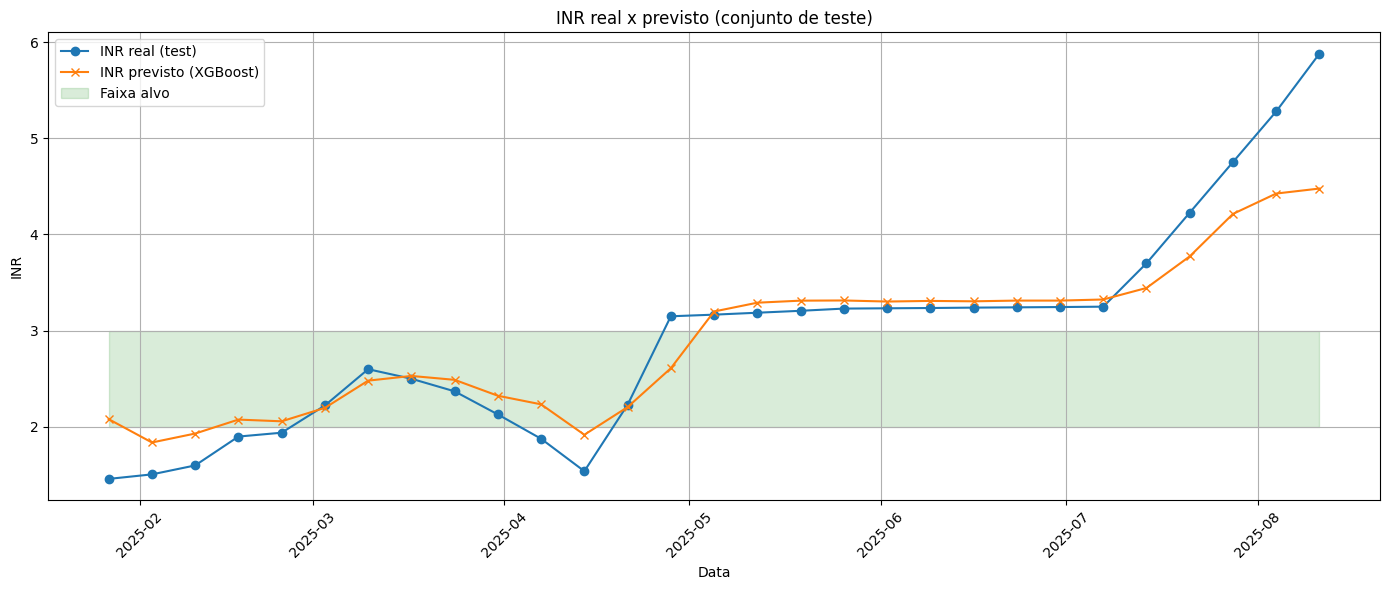

In [63]:
# PLOTS: Atual vs Previsto e Faixa Alvo
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test.values, label='INR real (test)', marker='o')
plt.plot(dates_test, y_pred_test, label='INR previsto (XGBoost)', marker='x')
# banda alvo (usar low/high arrays)
plt.fill_between(dates_test, low_vals, high_vals, color='green', alpha=0.15, label='Faixa alvo')
plt.xlabel("Data")
plt.ylabel("INR")
plt.title("INR real x previsto (conjunto de teste)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

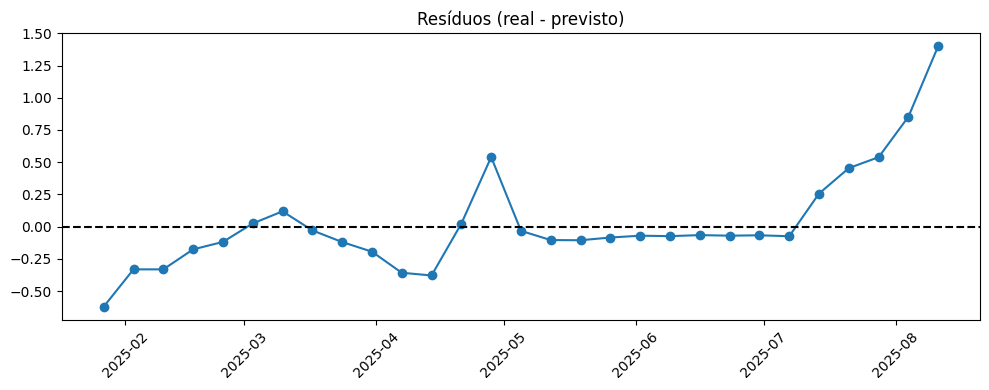

In [64]:
# Residuals
plt.figure(figsize=(10,4))
resid = y_test.values - y_pred_test
plt.plot(dates_test, resid, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.title("Resíduos (real - previsto)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\1265125338.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


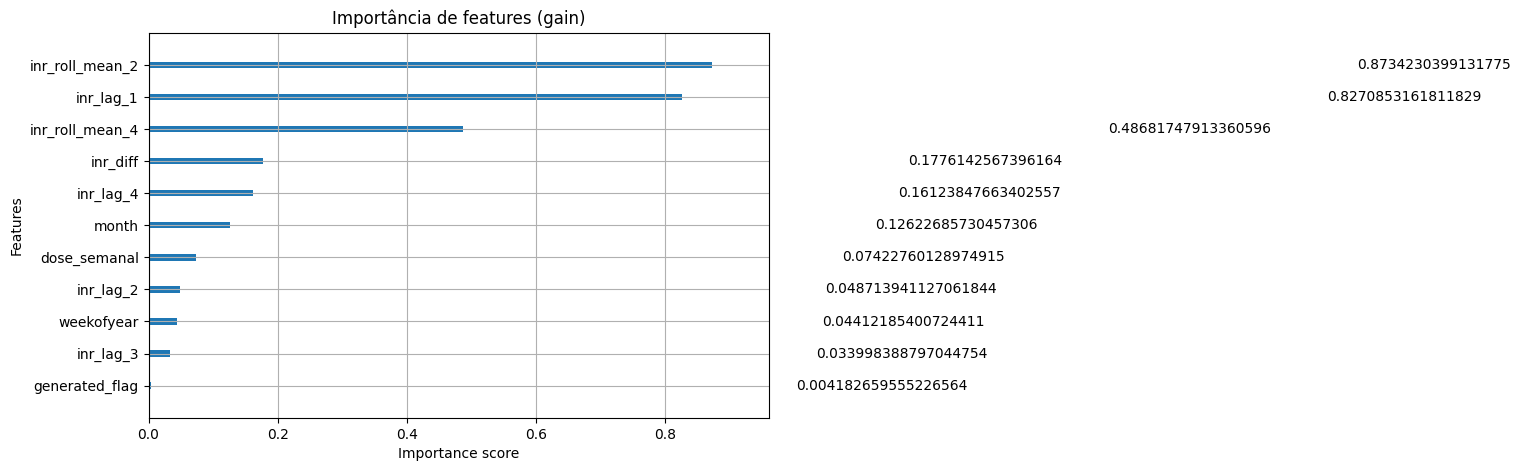

In [65]:
# Feature importance (SHAP seria melhor; aqui importância do modelo)
fig, ax = plt.subplots(figsize=(8,5))
xgb.plot_importance(model, max_num_features=15, ax=ax, importance_type='gain')
plt.title("Importância de features (gain)")
plt.tight_layout()
plt.show()

### 2.2 XGBoost com GridSearch

In [66]:
# TIME SERIES SPLIT + GRIDSEARCHCV PARA TUNING
tscv = TimeSeriesSplit(n_splits=5)

model_xgb = xgb.XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror")

# PARÂMETROS PARA TESTAR  (ajuste conforme necessário)
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "gamma": [0, 1],
    "min_child_weight": [1, 3, 5]
}

print("Iniciando GridSearchCV com validação temporal...")

grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n===== RESULTADO DO TUNING =====")
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print(f"MAE médio (validação): {-grid_search.best_score_:.4f}")

best_params = grid_search.best_params_

Iniciando GridSearchCV com validação temporal...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

===== RESULTADO DO TUNING =====
Melhores parâmetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.9}
MAE médio (validação): 0.2915


In [67]:
# TREINAR MODELO FINAL COM MELHORES PARÂMETROS
model = xgb.XGBRegressor(
    **best_params,
    random_state=RANDOM_STATE,
    objective="reg:squarederror",
    verbosity=0
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [68]:
# PREVISÕES
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# MÉTRICAS
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")

MAE train: 0.0090 | MAE test: 0.2324
RMSE train: 0.0001 | RMSE test: 0.1427


In [69]:
# MÉTRICAS PERSONALIZADAS (FAIXA ALVO)
def pct_within_range(y_true, y_pred, low, high):
    within = ((y_pred >= low) & (y_pred <= high)).sum()
    return within / len(y_pred) * 100

def avg_distance_to_range(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    dist = np.where(
        y_pred < low, low - y_pred,
        np.where(y_pred > high, y_pred - high, 0.0)
    )
    return float(np.mean(dist))

low_vals = df1['low_range'].iloc[n_train:].values
high_vals = df1['high_range'].iloc[n_train:].values

pct_in_range_pred = pct_within_range(y_test.values, y_test, low_vals, high_vals)
avg_dist_pred = avg_distance_to_range(y_test, low_vals, high_vals)

print(f"% previsões dentro da faixa alvo (test): {pct_in_range_pred:.2f}%")
print(f"Distância média até a faixa alvo (test): {avg_dist_pred:.4f}")

% previsões dentro da faixa alvo (test): 34.48%
Distância média até a faixa alvo (test): 0.2838


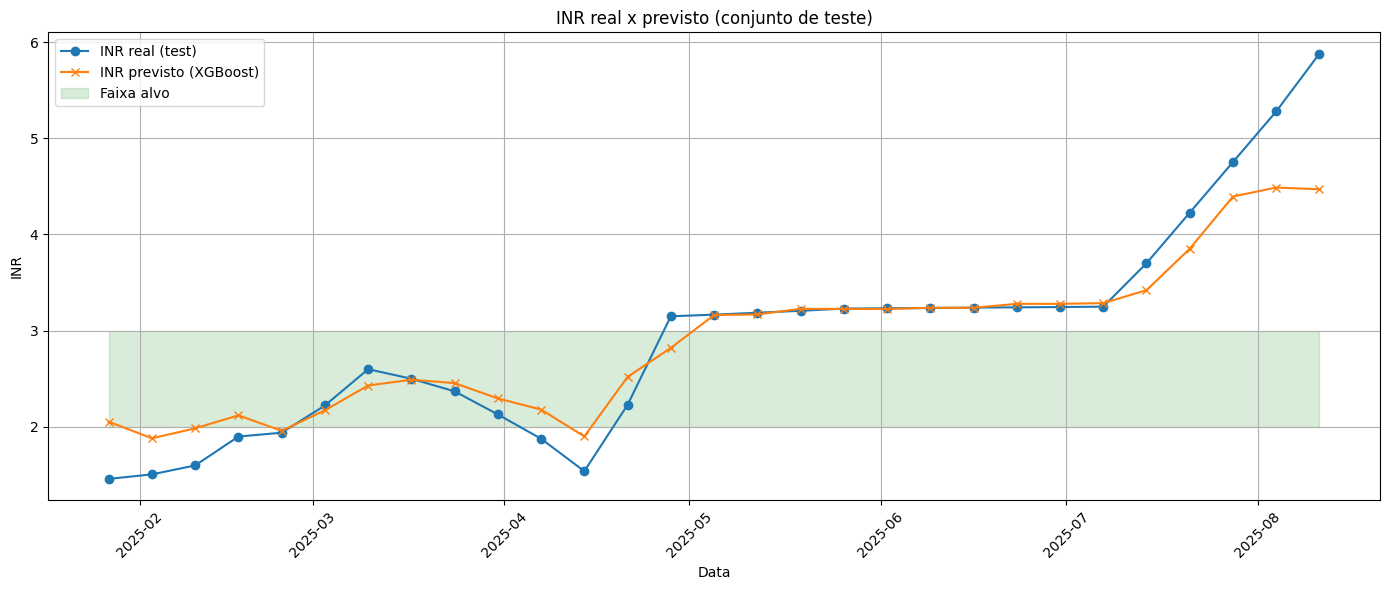

In [70]:
# PLOT – REAL VS PREVISTO
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test.values, label='INR real (test)', marker='o')
plt.plot(dates_test, y_pred_test, label='INR previsto (XGBoost)', marker='x')
plt.fill_between(dates_test, low_vals, high_vals, color='green', alpha=0.15, label='Faixa alvo')
plt.xlabel("Data")
plt.ylabel("INR")
plt.title("INR real x previsto (conjunto de teste)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

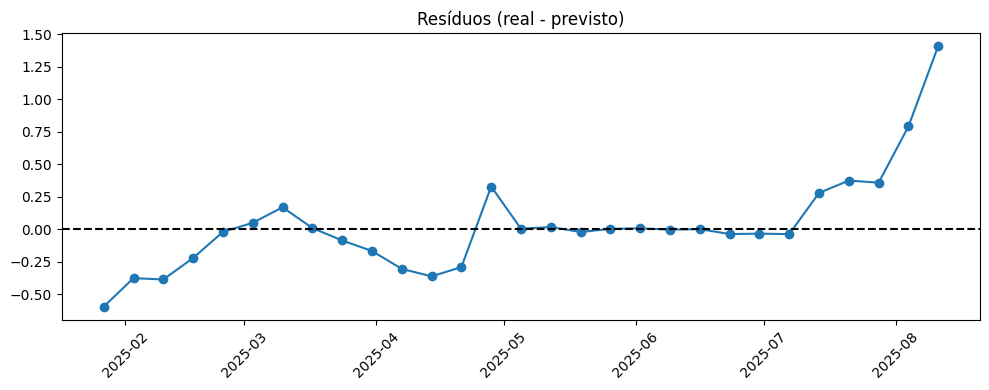

In [71]:
# PLOT – RESÍDUOS
plt.figure(figsize=(10,4))
resid = y_test.values - y_pred_test
plt.plot(dates_test, resid, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.title("Resíduos (real - previsto)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

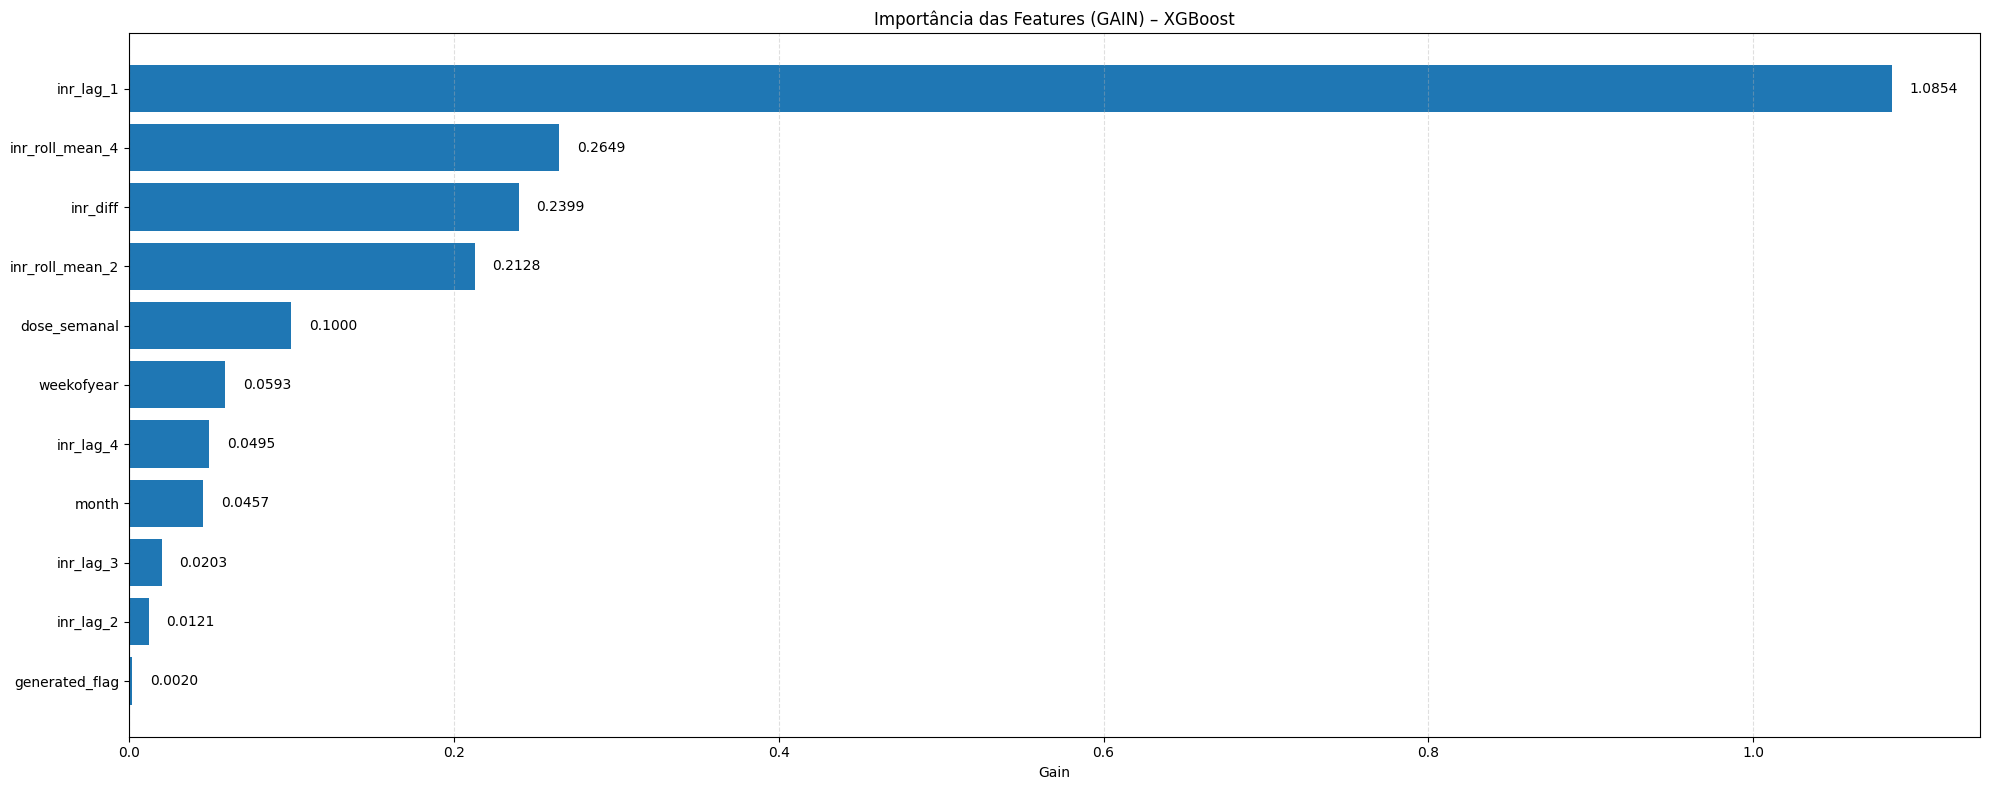

In [77]:
# Importância das features
importance = model.get_booster().get_score(importance_type='gain')

# converter para dataframe ordenado
imp_df = pd.DataFrame({
    "feature": list(importance.keys()),
    "gain": list(importance.values())
}).sort_values("gain", ascending=True)  # horizontal (de baixo para cima)

# filtrar top 15
imp_df = imp_df.tail(15)

# plot
plt.figure(figsize=(20, 8))
bars = plt.barh(imp_df["feature"], imp_df["gain"])

# adicionar valores ao lado das barras
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (max(imp_df["gain"]) * 0.01),
        bar.get_y() + bar.get_height()/2,
        f"{width:.4f}",
        va='center'
    )

plt.xlabel("Gain")
plt.title("Importância das Features (GAIN) – XGBoost")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 2.3 Plotando recomendação

In [78]:
def build_next_week_features(last_row, feature_cols, date_col='test_date', target_col='inr', freq_days=7):
    """
    Constrói um DataFrame (1 linha) com as features necessárias para predizer a próxima semana,
    a partir da última observação (last_row: pd.Series).
    - last_row: pd.Series (última linha observada, com colunas usadas nas features)
    - feature_cols: lista das colunas de entrada que o modelo espera (por ex. ['dose_semanal','inr_lag_1',...])
    - retorna: pd.DataFrame com 1 linha, colunas = feature_cols
    -----------------------------------------
    Observações/assunções:
    - Lags: inr_lag_1 será o inr atual (last_row['inr']), inr_lag_2 será last_row['inr_lag_1'], etc.
      Se alguma lag não existir em last_row (por exemplo você usou menos lags), preenche com NaN -> 0.
    - Rolling: inr_roll_mean_w usa last_row's rolling e o incorpora sem recomputar usando histórico longo.
      Aqui assumimos rolling já presente em last_row como última média deslocada (como no pipeline anterior),
      então copiamos o valor existente. Se não existir, deixa NaN -> preencher depois.
    - Se precisar recalcular rolling usando histórico, passe o DataFrame inteiro e eu dou outra função.
    """
    # garantir série
    if not isinstance(last_row, pd.Series):
        raise ValueError("last_row deve ser uma pd.Series (última linha do dataset do paciente).")
    
    # construir uma linha vazia
    next_dict = {}
    
    # regra: para cada feature:
    for f in feature_cols:
        if f == 'dose_semanal':
            # manter mesma dose atual por default (ajuste só após recomendação)
            next_dict[f] = last_row.get('dose_semanal', np.nan)
            continue
        if f.startswith('inr_lag_'):
            # extrair número do lag
            try:
                lag = int(f.split('_')[-1])
            except:
                lag = None
            if lag is None:
                next_dict[f] = last_row.get(f, np.nan)
                continue
            # inr_lag_1 (próximo passo) deve ser o inr atual
            if lag == 1:
                next_dict[f] = last_row.get('inr', last_row.get('inr_lag_1', np.nan))
            else:
                # inr_lag_2_next = last_row['inr_lag_1'], inr_lag_3_next = last_row['inr_lag_2'], etc.
                prev_name = f'inr_lag_{lag-1}'
                next_dict[f] = last_row.get(prev_name, np.nan)
            continue
        if f.startswith('inr_roll_mean_'):
            # assumimos que a média rolante já foi calculada e está deslocada (shifted) no last_row
            # então copiamos o valor atual (que foi calculado com dados até last_row)
            next_dict[f] = last_row.get(f, np.nan)
            continue
        if f == 'inr_diff':
            # inr_diff para o "próximo" previsto não é conhecido; podemos usar last diff
            next_dict[f] = last_row.get('inr_diff', np.nan)
            continue
        if f == 'generated_flag' or f == 'generated':
            # o próximo ponto ainda não é gerado; marcar 1 se quisermos indicar que é uma previsão (0 default)
            next_dict[f] = 0
            continue
        # features temporais (week/month/day) podem ser inferidas incrementando a data
        if f in ['weekofyear', 'month', 'year', 'dayofweek']:
            # data do próximo ponto:
            last_date = pd.to_datetime(last_row.get(date_col))
            next_date = last_date + pd.Timedelta(days=int(freq_days))
            if f == 'weekofyear':
                next_dict[f] = int(next_date.isocalendar().week)
            elif f == 'month':
                next_dict[f] = int(next_date.month)
            elif f == 'year':
                next_dict[f] = int(next_date.year)
            elif f == 'dayofweek':
                next_dict[f] = int(next_date.weekday())
            continue
        # fallback: se a coluna existe em last_row, copie; senão NaN
        next_dict[f] = last_row.get(f, np.nan)
    
    X_next = pd.DataFrame([next_dict], columns=feature_cols)
    # preencher NaNs razoavelmente (ffill/backfill conforme disponibilidade)
    X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
    return X_next


def recommend_dose_from_prediction(model, X_next, last_dose, low, high,
                                   pct_small=0.10, pct_large=0.15,
                                   warn_threshold=1.0):
    """
    Recebe:
      - model: modelo treinado (ex: XGBRegressor)
      - X_next: pd.DataFrame (1 linha) com features da próxima semana
      - last_dose: último dose_semanal registrado (float)
      - low, high: limites alvo (float)
      - pct_small: 0.10 => 10% (ajuste quando pred diff <= 0.5)
      - pct_large: 0.15 => 15% (ajuste quando pred diff <= 1.0)
      - warn_threshold: se diferença > warn_threshold, sinaliza avaliação clínica
    
    Retorna dicionário com:
      - prediction: valor previsto do INR
      - decision: 'increase'/'decrease'/'none'
      - recommended_pct: percentual (positivo para aumento, negativo para redução)
      - recommended_dose: novo valor da dose_semanal sugerida
      - reason: texto explicativo
      - alert: True/False se diferença > warn_threshold (aconselhar consulta médica)
    """
    if X_next.shape[0] != 1:
        raise ValueError("X_next deve ter exatamente 1 linha.")
    # previsão
    pred = float(model.predict(X_next)[0])
    
    # inicial padrão: sem mudança
    decision = 'none'
    recommended_pct = 0.0
    recommended_dose = float(last_dose)
    alert = False
    reason = "Predição dentro da faixa alvo — sem ajuste recomendado."

    # se dentro da faixa:
    if low <= pred <= high:
        return {
            "prediction": pred,
            "decision": decision,
            "recommended_pct": recommended_pct,
            "recommended_dose": recommended_dose,
            "reason": reason,
            "alert": alert
        }
    
    # se abaixo do mínimo
    if pred < low:
        diff = low - pred
        # tiny deviation: up to 0.5 -> +pct_small
        if diff <= 0.5:
            recommended_pct = pct_small
            decision = 'increase'
            reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Recomenda-se aumento conservador de {pct_small*100:.0f}% na dose semanal."
        elif diff <= 1.0:
            recommended_pct = pct_large
            decision = 'increase'
            reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Recomenda-se aumento de {pct_large*100:.0f}% na dose semanal."
        else:
            # muito abaixo -> alertar
            recommended_pct = pct_large
            decision = 'increase'
            alert = True
            reason = (f"Predito {diff:.3f} abaixo do limite inferior ({low}). Diferença grande (> {warn_threshold}). "
                      f"Recomenda-se avaliação clínica; sugestão inicial: aumento de {pct_large*100:.0f}% para verificação.")
        # calcular nova dose
        recommended_dose = float(last_dose) * (1.0 + recommended_pct)
        return {
            "prediction": pred,
            "decision": decision,
            "recommended_pct": recommended_pct,
            "recommended_dose": recommended_dose,
            "reason": reason,
            "alert": alert
        }
    
    # se acima do máximo
    if pred > high:
        diff = pred - high
        if diff <= 0.5:
            recommended_pct = -pct_small
            decision = 'decrease'
            reason = f"Predito {diff:.3f} acima do limite superior ({high}). Recomenda-se redução conservadora de {pct_small*100:.0f}% na dose semanal."
        elif diff <= 1.0:
            recommended_pct = -pct_large
            decision = 'decrease'
            reason = f"Predito {diff:.3f} acima do limite superior ({high}). Recomenda-se redução de {pct_large*100:.0f}% na dose semanal."
        else:
            recommended_pct = -pct_large
            decision = 'decrease'
            alert = True
            reason = (f"Predito {diff:.3f} acima do limite superior ({high}). Diferença grande (> {warn_threshold}). "
                      f"Recomenda-se avaliação clínica; sugestão inicial: redução de {pct_large*100:.0f}% para verificação.")
        recommended_dose = float(last_dose) * (1.0 + recommended_pct)
        return {
            "prediction": pred,
            "decision": decision,
            "recommended_pct": recommended_pct,
            "recommended_dose": recommended_dose,
            "reason": reason,
            "alert": alert
        }

In [79]:
# supondo que você tem:
# - model (XGBoost treinado)
# - feature_cols (lista de features que o modelo usa, na ordem correta)
# - df_features (DataFrame com as features geradas por create_time_features, ordenado por date asc)

# pegar última linha observada do paciente
last_row = df1.iloc[-1]   # pd.Series

# construir features da próxima semana
X_next = build_next_week_features(last_row, feature_cols=fc1, date_col=DATE_COL, target_col=TARGET_COL)

# chamar recomendador
last_dose = float(last_row['dose_semanal'])
low = float(last_row['low_range'])
high = float(last_row['high_range'])

recommendation = recommend_dose_from_prediction(model, X_next, last_dose, low, high,
                                                pct_small=0.10, pct_large=0.15, warn_threshold=1.0)

# mostrar resultado
print("Previsão INR próxima semana:", recommendation['prediction'])
print("Decisão:", recommendation['decision'])
print("Recomendação (%):", f"{recommendation['recommended_pct']*100:.1f}%")
print("Dose semanal atual:", last_dose)
print("Dose semanal sugerida:", round(recommendation['recommended_dose'], 2))
print("Alerta clínico:", recommendation['alert'])
print("Explicação:", recommendation['reason'])

Previsão INR próxima semana: 4.592858791351318
Decisão: decrease
Recomendação (%): -15.0%
Dose semanal atual: 47.5
Dose semanal sugerida: 40.38
Alerta clínico: True
Explicação: Predito 1.593 acima do limite superior (3.0). Diferença grande (> 1.0). Recomenda-se avaliação clínica; sugestão inicial: redução de 15% para verificação.


C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\296278101.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\296278101.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)


### 2.4 Plotanco recomendação 2.0

In [82]:
# ========== Função auxiliar: atualiza lags e rolling a partir de histórico ==========
def _update_lags_and_rolls(feature_cols, history_inr, roll_windows):
    """
    Dado history_inr (lista, último item = inr mais recente observado/predito),
    retorna um dict com chaves 'inr_lag_k' e 'inr_roll_mean_w' preenchidas
    de acordo com feature_cols presentes.
    """
    d = {}
    # identificar lags solicitados nas feature_cols
    lag_cols = [c for c in feature_cols if c.startswith('inr_lag_')]
    # ordenar por lag crescente (inr_lag_1, inr_lag_2, ...)
    lag_nums = sorted([int(c.split('_')[-1]) for c in lag_cols]) if lag_cols else []
    # preencher lags: inr_lag_1 = history_inr[-1], inr_lag_2 = history_inr[-2], ...
    for k in lag_nums:
        idx = -k  # -1 => último, -2 => penúltimo
        if len(history_inr) >= k:
            d[f'inr_lag_{k}'] = float(history_inr[idx])
        else:
            # se não houver histórico suficiente, preencher com NaN (ou 0)
            d[f'inr_lag_{k}'] = float(np.nan)

    # rolling means: inr_roll_mean_w = média dos últimos w valores (sem incluir o valor futuro)
    for w in roll_windows:
        if len(history_inr) >= 1:
            # média dos últimos w valores (ou de todos se menos que w)
            vals = history_inr[-w:] if len(history_inr) >= w else history_inr[:]
            d[f'inr_roll_mean_{w}'] = float(np.mean(vals)) if len(vals) > 0 else float(np.nan)
        else:
            d[f'inr_roll_mean_{w}'] = float(np.nan)

    return d

# ========== Função para construir vetor de features para o próximo passo ==========
def build_feature_vector_next_step(last_date, last_history_inr, last_row, feature_cols,
                                   date_col='test_date', freq_days=7, roll_windows=None):
    """
    Constrói um DataFrame (1 linha) contendo as features que o modelo espera para
    a próxima semana (ou próximo passo com freq_days).
    - last_date: ultima data observada (pd.Timestamp)
    - last_history_inr: lista de floats com histórico de INR (ordem cronológica, último = mais recente)
    - last_row: pd.Series contendo colunas auxiliares (dose_semanal, inr_diff, low_range, high_range, generated, etc.)
    - feature_cols: lista de features que o modelo espera (nomes)
    - roll_windows: lista de janelas rolling já usadas no pipeline (ex: [3,4])
    """
    if roll_windows is None:
        # extrair roll windows que podem existir no feature_cols
        roll_windows = []
        for c in feature_cols:
            if c.startswith('inr_roll_mean_'):
                try:
                    roll_windows.append(int(c.split('_')[-1]))
                except:
                    pass
        roll_windows = sorted(set(roll_windows))

    next_date = pd.to_datetime(last_date) + pd.Timedelta(days=int(freq_days))
    vec = {}

    # preencher features temporais
    if 'weekofyear' in feature_cols:
        vec['weekofyear'] = int(next_date.isocalendar().week)
    if 'month' in feature_cols:
        vec['month'] = int(next_date.month)
    if 'year' in feature_cols:
        vec['year'] = int(next_date.year)
    if 'dayofweek' in feature_cols:
        vec['dayofweek'] = int(next_date.weekday())

    # dose_semanal: por default pegar a última registrada (ajuste será sugerido depois)
    if 'dose_semanal' in feature_cols:
        vec['dose_semanal'] = float(last_row.get('dose_semanal', np.nan))

    # inr_diff: usar último inr_diff (poderia ser estimado, mas mantemos último)
    if 'inr_diff' in feature_cols:
        vec['inr_diff'] = float(last_row.get('inr_diff', 0.0))

    # generated flag: futuro ainda não gerado -> 0
    if 'generated_flag' in feature_cols or 'generated' in feature_cols:
        # detectar qual nome está na lista e preencher
        if 'generated_flag' in feature_cols:
            vec['generated_flag'] = int(0)
        if 'generated' in feature_cols:
            vec['generated'] = int(0)

    # low_range, high_range (copiar do last_row)
    if 'low_range' in feature_cols:
        vec['low_range'] = float(last_row.get('low_range', np.nan))
    if 'high_range' in feature_cols:
        vec['high_range'] = float(last_row.get('high_range', np.nan))

    # atualizar lags e rolling via histórico (history inclui valores reais + previsões já geradas)
    lag_and_roll = _update_lags_and_rolls(feature_cols, last_history_inr, roll_windows)
    vec.update(lag_and_roll)

    # preencher quaisquer outras features que possam simplesmente ser copiadas do last_row
    for f in feature_cols:
        if f in vec:
            continue
        if f in last_row.index:
            vec[f] = last_row.get(f)
        else:
            # valor padrão
            vec[f] = float(np.nan)

    # manter apenas as colunas na ordem feature_cols
    row = {c: vec.get(c, np.nan) for c in feature_cols}
    X_next = pd.DataFrame([row], columns=feature_cols)
    # preencher NaNs com estratégia conservadora: forward/backfill com zeros em último caso
    X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
    return X_next, next_date

# ========== Função principal: previsão multi-step + recomendações ==========
def multi_step_forecast_and_recommend(model, df_features, feature_cols,
                                      horizon=4, freq_days=7,
                                      pct_small=0.10, pct_large=0.15, warn_threshold=1.0,
                                      max_pct_change=0.20):
    """
    Gera previsões multi-step e recomendações de dose para cada passo.
    - model: modelo treinado (XGBRegressor)
    - df_features: DataFrame com histórico (ordenado por data asc), deve conter a última linha observada
    - feature_cols: lista de features que o modelo espera
    - horizon: número de passos (semanas) à frente para prever
    - pct_small / pct_large / warn_threshold / max_pct_change: regras de ajuste
    Retorna DataFrame com colunas:
      ['step','date','prediction','last_dose','recommended_pct','recommended_dose','decision','alert','reason']
    """
    # validações mínimas
    if df_features is None or len(df_features) == 0:
        raise ValueError("df_features vazio.")
    df = df_features.copy().reset_index(drop=True)
    last_row = df.iloc[-1]
    last_date = pd.to_datetime(last_row['test_date'])
    # construir histórico de INR (lista), último = mais recente
    # tomar um histórico razoável (por ex. últimos 12 valores) para calcular rolls; aqui usamos todo o histórico disponível
    history_inr = df['inr'].dropna().astype(float).tolist()
    # assegurar que history_inr[-1] é o valor mais recente (deveria ser)
    if len(history_inr) == 0:
        raise ValueError("Sem histórico de INR válido para construir previsões.")

    # descobrir roll windows que existem entre feature_cols
    roll_windows = sorted({int(c.split('_')[-1]) for c in feature_cols if c.startswith('inr_roll_mean_')})

    rows_out = []
    current_history = history_inr[:]  # copia mutável
    current_last_row = last_row.copy()

    # iterative multi-step
    for step in range(1, horizon + 1):
        # construir features para próximo passo
        X_next, next_date = build_feature_vector_next_step(
            last_date=current_last_row['test_date'] if 'test_date' in current_last_row.index else last_date,
            last_history_inr=current_history,
            last_row=current_last_row,
            feature_cols=feature_cols,
            date_col='test_date',
            freq_days=freq_days,
            roll_windows=roll_windows
        )

        # prever
        pred = float(model.predict(X_next)[0])

        # recomendação baseada na regra
        low = float(current_last_row.get('low_range', np.nan))
        high = float(current_last_row.get('high_range', np.nan))
        # fallback se low/high NaN: usar defaults (opcional)
        if np.isnan(low):
            low = 2.5
        if np.isnan(high):
            high = 3.5

        # cálculo decisão
        decision = 'none'
        recommended_pct = 0.0
        recommended_dose = float(current_last_row.get('dose_semanal', np.nan))
        alert = False
        reason = "Dentro da faixa alvo."

        if low <= pred <= high:
            decision = 'none'
            recommended_pct = 0.0
            recommended_dose = float(current_last_row.get('dose_semanal', np.nan))
            reason = "Previsão dentro da faixa alvo. Sem ajuste."
        elif pred < low:
            diff = low - pred
            if diff <= 0.5:
                recommended_pct = pct_small
                decision = 'increase'
                reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Aumentar {pct_small*100:.0f}%."
            elif diff <= 1.0:
                recommended_pct = pct_large
                decision = 'increase'
                reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Aumentar {pct_large*100:.0f}%."
            else:
                recommended_pct = pct_large
                decision = 'increase'
                alert = True
                reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Diferença grande; avaliar clinicamente. Sugestão: +{pct_large*100:.0f}%."
        else:  # pred > high
            diff = pred - high
            if diff <= 0.5:
                recommended_pct = -pct_small
                decision = 'decrease'
                reason = f"Predito {diff:.3f} acima do limite superior ({high}). Reduzir {pct_small*100:.0f}%."
            elif diff <= 1.0:
                recommended_pct = -pct_large
                decision = 'decrease'
                reason = f"Predito {diff:.3f} acima do limite superior ({high}). Reduzir {pct_large*100:.0f}%."
            else:
                recommended_pct = -pct_large
                decision = 'decrease'
                alert = True
                reason = f"Predito {diff:.3f} acima do limite superior ({high}). Diferença grande; avaliar clinicamente. Sugestão: -{pct_large*100:.0f}%."

        # aplicar clip de segurança (ex: não mais que max_pct_change em magnitude)
        if recommended_pct != 0.0:
            if recommended_pct > 0:
                recommended_pct = min(recommended_pct, max_pct_change)
            else:
                recommended_pct = max(recommended_pct, -max_pct_change)

        last_dose = float(current_last_row.get('dose_semanal', np.nan))
        if np.isnan(last_dose):
            # fallback
            last_dose = 100.0

        recommended_dose = float(last_dose * (1.0 + recommended_pct))

        # armazenar saída do passo
        rows_out.append({
            'step': step,
            'date': pd.to_datetime(next_date),
            'prediction': pred,
            'last_dose': last_dose,
            'recommended_pct': recommended_pct,
            'recommended_dose': recommended_dose,
            'decision': decision,
            'alert': alert,
            'reason': reason,
            'low': low,
            'high': high
        })

        # atualizar histórico e last_row para o próximo passo (autorregressivo)
        current_history.append(pred)   # usar a previsão como novo ponto na história
        # atualizar current_last_row: copy e ajustar valores que mudam para o próximo passo
        # - test_date passa a next_date
        # - dose_semanal: assumir que a dose NÃO foi aplicada automaticamente; mantemos last_dose here.
        #   Se você quiser simular aplicação da recomendação, substitua com recommended_dose.
        current_last_row = current_last_row.copy()
        current_last_row['test_date'] = pd.to_datetime(next_date)
        # manter dose_semanal como última observada para a construção de features; não aplicamos a recomendação automaticamente
        # se quiser simular a aplicação, substitua a linha acima por:
        # current_last_row['dose_semanal'] = recommended_dose
        # atualiza inr (último valor) para permitir construção de lags subsequentemente
        current_last_row['inr'] = pred
        # atualiza inr_diff como pred - anterior real
        prev_inr = current_history[-2] if len(current_history) >= 2 else pred
        current_last_row['inr_diff'] = pred - prev_inr

    # retornar tabela
    out_df = pd.DataFrame(rows_out)
    return out_df

In [83]:
# ========== Exemplo de uso ==========
# - model: seu XGBoost treinado
# - df_features: DataFrame com histórico, ordenado por date asc, e com colunas usadas no feature_cols
# - feature_cols: lista de features que o modelo espera

# Exemplo:
df_features = df1  # já existente
feature_cols = fc1  # ou a lista que você usou para treinar

# fazer previsão multi-step (ex.: 4 semanas)
out = multi_step_forecast_and_recommend(model, df_features, feature_cols, horizon=4)
display(out)

C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\2385390970.py:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\2385390970.py:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\2385390970.py:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
C:\Users\pedro\AppData\Local\Temp\ipykernel_2688\2385390970.py:109: FutureWarning: DataFrame.fillna with 'method' is d

,step,date,prediction,last_dose,recommended_pct,recommended_dose,decision,alert,reason,low,high
0,1,2025-08-18,4.592859,47.5,-0.15,40.375,decrease,True,Predito 1.593 acima do limite superior (3.0). ...,2.0,3.0
1,2,2025-08-25,2.255893,47.5,0.00,47.500,none,False,Previsão dentro da faixa alvo. Sem ajuste.,2.0,3.0
2,3,2025-09-01,1.828350,47.5,0.10,52.250,increase,False,Predito 0.172 abaixo do limite inferior (2.0)....,2.0,3.0
3,4,2025-09-08,1.851414,47.5,0.10,52.250,increase,False,Predito 0.149 abaixo do limite inferior (2.0)....,2.0,3.0


## 3. Treinando LightGBM

### 3.1 LightGBM com hiperparâmetros fixos

In [ ]:
LGB_PARAMS = {
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "random_state": RANDOM_STATE,
    "n_jobs": -1
}

In [105]:
# CONVERSÃO PARA DMatrix LIGHTGBM (opcional)
# Podemos chamar .fit direto no LGBMRegressor, mas usando Dataset ajuda em alguns fluxos
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

# TREINAMENTO
model = lgb.LGBMRegressor(**LGB_PARAMS)

# Usar early stopping com eval_set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
)

# PREVISÕES E MÉTRICAS
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration_)
y_pred_test  = model.predict(X_test,  num_iteration=model.best_iteration_)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test  = mean_squared_error(y_test, y_pred_test)

print("==== Métricas ====")
print(f"MAE (train): {mae_train:.4f} | MAE (test): {mae_test:.4f}")
print(f"RMSE(train): {rmse_train:.4f} | RMSE(test): {rmse_test:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 11
[LightGBM] [Info] Start training from score 2.972776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [106]:
# MÉTRICAS RELACIONADAS À FAIXA ALVO (low/high)
low_vals = df1['low_range'].iloc[n_train:].values if 'low_range' in df1.columns else np.full(len(y_test), 2.5)
high_vals = df1['high_range'].iloc[n_train:].values if 'high_range' in df1.columns else np.full(len(y_test), 3.5)

def pct_within_range_array(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    return ((y_pred >= low) & (y_pred <= high)).mean() * 100.0

def avg_distance_to_range_array(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    dist = np.where(y_pred < low, low - y_pred,
                    np.where(y_pred > high, y_pred - high, 0.0))
    return float(np.mean(dist))

pct_in_range = pct_within_range_array(y_pred_test, low_vals, high_vals)
avg_dist = avg_distance_to_range_array(y_pred_test, low_vals, high_vals)

print(f"% previsões dentro da faixa alvo (test): {pct_in_range:.2f}%")
print(f"Distância média até faixa (test): {avg_dist:.4f}")

% previsões dentro da faixa alvo (test): 48.28%
Distância média até faixa (test): 0.3551


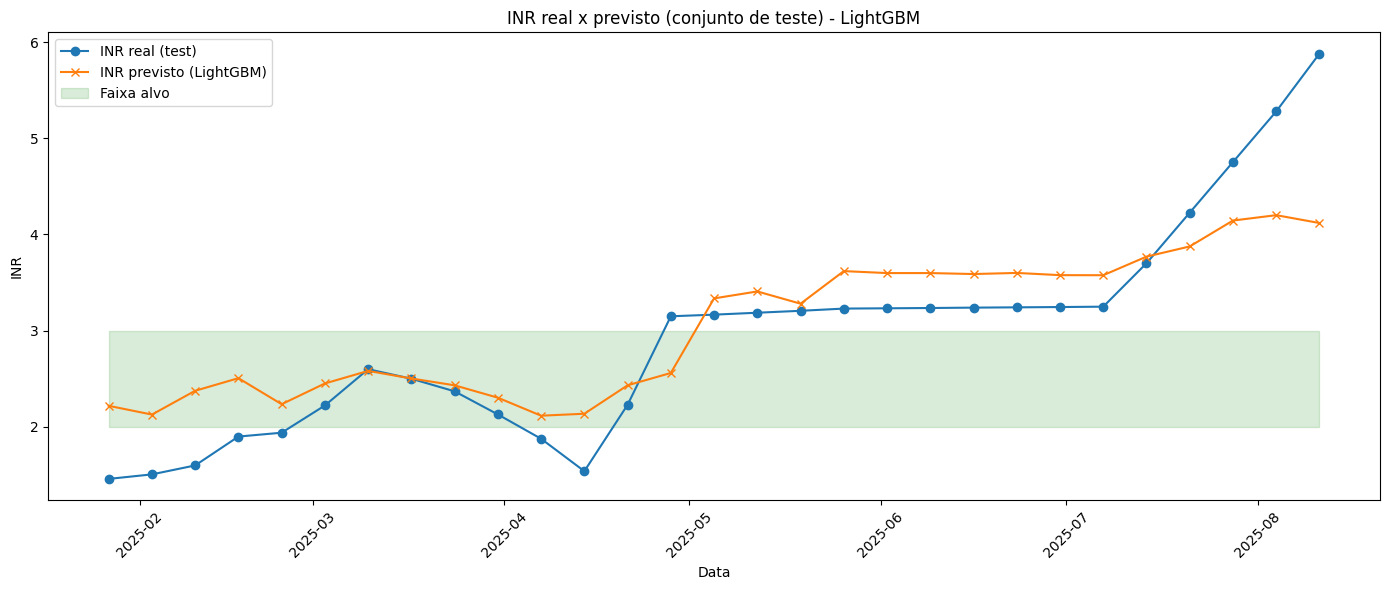

In [108]:
# REAL x PREVISTO (TEST)
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test.values, label='INR real (test)', marker='o')
plt.plot(dates_test, y_pred_test, label='INR previsto (LightGBM)', marker='x')
plt.fill_between(dates_test, low_vals, high_vals, color='green', alpha=0.15, label='Faixa alvo')
plt.xlabel("Data")
plt.ylabel("INR")
plt.title("INR real x previsto (conjunto de teste) - LightGBM")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

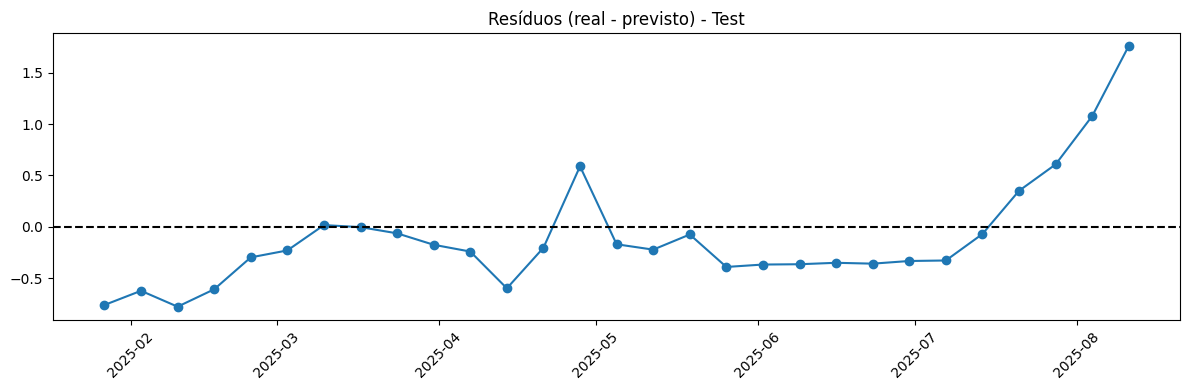

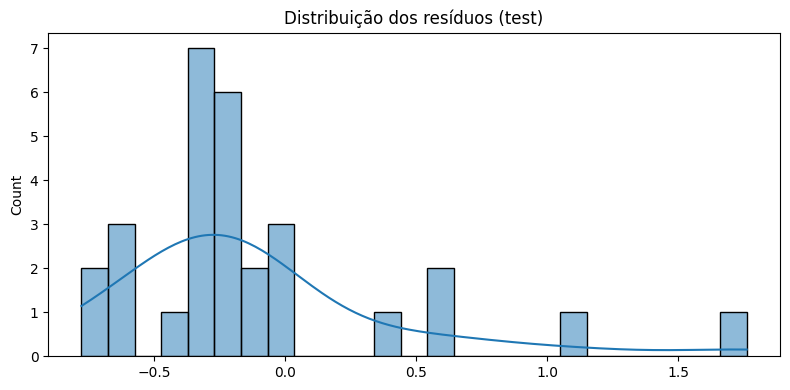

In [111]:
# RESÍDUOS (tempo)
plt.figure(figsize=(12,4))
resid = y_test.values - y_pred_test
plt.plot(dates_test, resid, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.title("Resíduos (real - previsto) - Test")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# HISTOGRAMA DOS RESÍDUOS
plt.figure(figsize=(8,4))
sns.histplot(resid, bins=25, kde=True)
plt.title("Distribuição dos resíduos (test)")
plt.tight_layout()
plt.show()

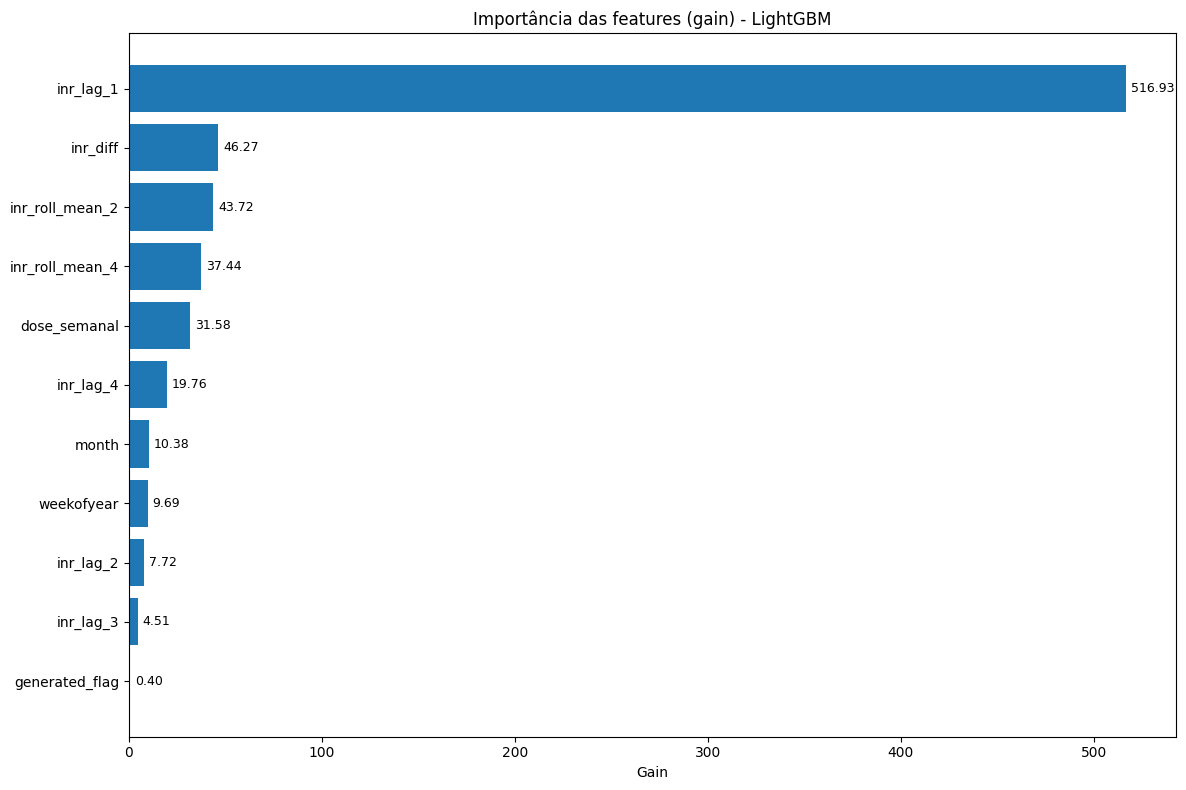

In [112]:
# IMPORTÂNCIA DAS FEATURES (GAIN) - barra horizontal com valores
gain = model.booster_.feature_importance(importance_type='gain')
feat_names = model.booster_.feature_name()
imp_df = pd.DataFrame({'feature': feat_names, 'gain': gain})
imp_df = imp_df.sort_values('gain', ascending=True).tail(30)  # top 30 por exemplo

plt.figure(figsize=(12,8))
bars = plt.barh(imp_df['feature'], imp_df['gain'])
for bar in bars:
    w = bar.get_width()
    plt.text(w + (imp_df['gain'].max() * 0.005), bar.get_y() + bar.get_height() / 2,
             f"{w:.2f}", va='center', fontsize=9)
plt.title("Importância das features (gain) - LightGBM")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

# ------------------------------
# SALVAR MODELO OPCIONAL (se quiser)
# ------------------------------
# model.booster_.save_model("lgbm_model.txt")
# ou usando joblib: import joblib; joblib.dump(model, "lgbm_model.pkl")

# ------------------------------
# NOTAS RÁPIDAS
# ------------------------------
# - LightGBM geralmente não precisa de normalização de features (árvores). 
# - Se quiser tuning, rode Grid / Optuna com TimeSeriesSplit.
# - Se houver colunas categóricSearchCVas, passe-as como 'categorical_feature' na criação do Dataset para LightGBM.

### 3.2 LightGBM com GridSearch

In [133]:
tscv = TimeSeriesSplit(n_splits=5)

# PARÂMETROS BASE (LightGBM)
base_params = {
    "objective": "regression",
    "metric": "mae",
    "random_state": RANDOM_STATE,
    "n_jobs": 1,  # GridSearch/Optuna fará paralelismo
    "verbosity": -1
}

# GRIDSEARCHCV (opcional)
grid_best_params = None

print("\n=== Iniciando GridSearchCV (TimeSeriesSplit) ===")
lgb_est = lgb.LGBMRegressor(**base_params)

# grade razoável (não muito extensa) — ajuste conforme recursos
param_grid = {
    "n_estimators": [200, 500],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 63],
    "max_depth": [-1, 6],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0.0, 0.1],
    "reg_lambda": [0.0, 0.1]
}

grid = GridSearchCV(
    estimator=lgb_est,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
grid_best_params = grid.best_params_
print("GridSearchCV best params:", grid_best_params)
print("GridSearchCV best CV MAE (neg):", grid.best_score_)


=== Iniciando GridSearchCV (TimeSeriesSplit) ===
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
GridSearchCV best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8}
GridSearchCV best CV MAE (neg): -0.5100614520768278


In [134]:
# OPTUNA (recomendado)
optuna_best_params = None

# função objetivo que usa cross_val_score com TimeSeriesSplit e scoring MAE
def objective(trial):
    # espaço de busca (defina limites razoáveis)
    param = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "random_state": RANDOM_STATE,
        "n_jobs": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }

    # usar cross_val_score com TimeSeriesSplit (scoring negativo MAE) — média dos folds
    model = lgb.LGBMRegressor(**param)
    # cross_val_score retornará array de scores (neg MAE)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=1)
    # queremos maximizar score (neg MAE) -> optuna maximiza por default se retornamos value; porém minimizamos MAE.
    # retornar média negativa (neg MAE) é compatível: optuna busca maximizar value; então retornar mean(scores)
    return float(np.mean(scores))

In [135]:
print("\n=== Iniciando Optuna (TimeSeriesSplit) ===")

# Criar estudo buscando maximizar neg MAE -> equivalente a minimizar MAE
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

print("Optuna best value (neg MAE mean):", study.best_value)
optuna_best_params = study.best_trial.params.copy()
# alguns parâmetros são contínuos na busca, mas LGBM espera ints; coerção:
optuna_best_params_converted = {
    **{k: int(v) if k in ["n_estimators", "num_leaves", "max_depth", "min_child_samples"] else v
        for k, v in optuna_best_params.items()}
}
print("Optuna best params (raw):", optuna_best_params)
print("Optuna best params (converted):", optuna_best_params_converted)

[I 2025-12-10 20:04:18,519] A new study created in memory with name: no-name-c98a7526-f6b1-4ebc-a8c0-5bdfd74ca307



=== Iniciando Optuna (TimeSeriesSplit) ===


Best trial: 2. Best value: -0.528074:   6%|▌         | 3/50 [00:00<00:02, 21.03it/s]

[I 2025-12-10 20:04:18,562] Trial 0 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'num_leaves': 98, 'max_depth': 8, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_child_samples': 62}. Best is trial 0 with value: -0.7817202075713312.
[I 2025-12-10 20:04:18,594] Trial 1 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171996, 'num_leaves': 125, 'max_depth': 11, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032198e-06, 'min_child_samples': 55}. Best is trial 0 with value: -0.7817202075713312.
[I 2025-12-10 20:04:18,660] Trial 2 finished with value: -0.5280737812920756 and parameters: {'n_estimators': 489, 'learning_rate': 0.02692655251486473, 'num_leaves': 85, 'max_depth': 

Best trial: 2. Best value: -0.528074:   6%|▌         | 3/50 [00:00<00:02, 21.03it/s]

[I 2025-12-10 20:04:18,697] Trial 3 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 563, 'learning_rate': 0.07500118950416987, 'num_leaves': 21, 'max_depth': 9, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_alpha': 3.4671276804481113, 'reg_lambda': 4.905556676028774, 'min_child_samples': 82}. Best is trial 2 with value: -0.5280737812920756.


Best trial: 2. Best value: -0.528074:  12%|█▏        | 6/50 [00:00<00:01, 22.69it/s]

[I 2025-12-10 20:04:18,758] Trial 4 finished with value: -0.5736487236721608 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'num_leaves': 93, 'max_depth': 7, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'reg_alpha': 2.039373116525212e-08, 'reg_lambda': 1.527156759251193, 'min_child_samples': 29}. Best is trial 2 with value: -0.5280737812920756.
[I 2025-12-10 20:04:18,791] Trial 5 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 696, 'learning_rate': 0.028869220380495747, 'num_leaves': 74, 'max_depth': 8, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_alpha': 0.09466630153726856, 'reg_lambda': 2.854239907497756, 'min_child_samples': 90}. Best is trial 2 with value: -0.5280737812920756.
[I 2025-12-10 20:04:18,825] Trial 6 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 638, 'learning_rate': 0.22999586428143728, 'num_leaves': 25, 'max_depth': 4, 'subsa

Best trial: 2. Best value: -0.528074:  18%|█▊        | 9/50 [00:00<00:01, 22.86it/s]

[I 2025-12-10 20:04:18,887] Trial 7 finished with value: -0.6318079247048629 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'num_leaves': 77, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_samples': 24}. Best is trial 2 with value: -0.5280737812920756.
[I 2025-12-10 20:04:18,916] Trial 8 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'num_leaves': 95, 'max_depth': 10, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07, 'min_child_samples': 87}. Best is trial 2 with value: -0.5280737812920756.


Best trial: 2. Best value: -0.528074:  18%|█▊        | 9/50 [00:00<00:01, 22.86it/s]

[I 2025-12-10 20:04:18,950] Trial 9 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 661, 'learning_rate': 0.030816017044468066, 'num_leaves': 23, 'max_depth': 6, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'reg_alpha': 0.005470376807480391, 'reg_lambda': 0.9658611176861268, 'min_child_samples': 50}. Best is trial 2 with value: -0.5280737812920756.


Best trial: 10. Best value: -0.369355:  20%|██        | 10/50 [00:00<00:01, 22.86it/s]

[I 2025-12-10 20:04:19,145] Trial 10 finished with value: -0.3693549913878461 and parameters: {'n_estimators': 951, 'learning_rate': 0.06819074809771597, 'num_leaves': 50, 'max_depth': 3, 'subsample': 0.8010124870699186, 'colsample_bytree': 0.8084932353340201, 'reg_alpha': 0.0009327366933736852, 'reg_lambda': 0.004137630881036823, 'min_child_samples': 8}. Best is trial 10 with value: -0.3693549913878461.


Best trial: 11. Best value: -0.347472:  24%|██▍       | 12/50 [00:00<00:03, 11.35it/s]

[I 2025-12-10 20:04:19,386] Trial 11 finished with value: -0.3474718523588167 and parameters: {'n_estimators': 997, 'learning_rate': 0.0800517600836598, 'num_leaves': 47, 'max_depth': 3, 'subsample': 0.8142497056141959, 'colsample_bytree': 0.792758531865332, 'reg_alpha': 0.0012136464952148106, 'reg_lambda': 0.0035148407688484953, 'min_child_samples': 5}. Best is trial 11 with value: -0.3474718523588167.


Best trial: 13. Best value: -0.341508:  28%|██▊       | 14/50 [00:01<00:04,  8.42it/s]

[I 2025-12-10 20:04:19,622] Trial 12 finished with value: -0.3445337982371079 and parameters: {'n_estimators': 971, 'learning_rate': 0.08811052657201125, 'num_leaves': 48, 'max_depth': 3, 'subsample': 0.8374709757162002, 'colsample_bytree': 0.8610724800899923, 'reg_alpha': 0.0044543722426483735, 'reg_lambda': 0.000793987808899461, 'min_child_samples': 5}. Best is trial 12 with value: -0.3445337982371079.
[I 2025-12-10 20:04:19,783] Trial 13 finished with value: -0.34150777863191156 and parameters: {'n_estimators': 997, 'learning_rate': 0.09154387249271213, 'num_leaves': 49, 'max_depth': 6, 'subsample': 0.828710827199778, 'colsample_bytree': 0.8900648344967426, 'reg_alpha': 0.028205929392862514, 'reg_lambda': 0.0005573797466124505, 'min_child_samples': 6}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  32%|███▏      | 16/50 [00:01<00:03,  8.57it/s]

[I 2025-12-10 20:04:19,862] Trial 14 finished with value: -0.641533297030979 and parameters: {'n_estimators': 843, 'learning_rate': 0.13323548338574384, 'num_leaves': 55, 'max_depth': 6, 'subsample': 0.8589085318772743, 'colsample_bytree': 0.9006453699263156, 'reg_alpha': 0.06850822067194212, 'reg_lambda': 6.639485089747668e-05, 'min_child_samples': 38}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:20,012] Trial 15 finished with value: -0.48183821217955974 and parameters: {'n_estimators': 860, 'learning_rate': 0.11446813431071286, 'num_leaves': 39, 'max_depth': 6, 'subsample': 0.8646061692551642, 'colsample_bytree': 0.8955315302425018, 'reg_alpha': 0.03378340620750534, 'reg_lambda': 0.003043263840972833, 'min_child_samples': 16}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  36%|███▌      | 18/50 [00:01<00:03,  9.42it/s]

[I 2025-12-10 20:04:20,092] Trial 16 finished with value: -0.6569980058783277 and parameters: {'n_estimators': 839, 'learning_rate': 0.0429454153173356, 'num_leaves': 62, 'max_depth': 12, 'subsample': 0.9542892386155918, 'colsample_bytree': 0.9644584031346586, 'reg_alpha': 0.5123800289855563, 'reg_lambda': 0.00011476383155632057, 'min_child_samples': 39}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:20,166] Trial 17 finished with value: -0.4733782204449849 and parameters: {'n_estimators': 292, 'learning_rate': 0.047502203623166296, 'num_leaves': 36, 'max_depth': 5, 'subsample': 0.7541938292846557, 'colsample_bytree': 0.8481784405972352, 'reg_alpha': 0.007645159361342282, 'reg_lambda': 9.629458488914864e-06, 'min_child_samples': 15}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:20,251] Trial 18 finished with value: -0.637497337983834 and parameters: {'n_estimators': 938, 'learning_rate': 0.0969193339743378, 'num_leaves': 64, 'max_depth

Best trial: 13. Best value: -0.341508:  40%|████      | 20/50 [00:01<00:03,  9.21it/s]

[I 2025-12-10 20:04:20,401] Trial 19 finished with value: -0.5120485742103702 and parameters: {'n_estimators': 787, 'learning_rate': 0.16522729299476804, 'num_leaves': 36, 'max_depth': 7, 'subsample': 0.7640881690357239, 'colsample_bytree': 0.8459435833294827, 'reg_alpha': 2.910443276351423e-06, 'reg_lambda': 0.0007527833242050526, 'min_child_samples': 13}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:20,443] Trial 20 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 890, 'learning_rate': 0.058194115192875484, 'num_leaves': 113, 'max_depth': 3, 'subsample': 0.9969456418305289, 'colsample_bytree': 0.8523232869351511, 'reg_alpha': 0.009327241201027694, 'reg_lambda': 0.02048002995866772, 'min_child_samples': 100}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  44%|████▍     | 22/50 [00:02<00:03,  8.44it/s]

[I 2025-12-10 20:04:20,686] Trial 21 finished with value: -0.34237098872712257 and parameters: {'n_estimators': 990, 'learning_rate': 0.08896427579326588, 'num_leaves': 50, 'max_depth': 3, 'subsample': 0.8096183749033755, 'colsample_bytree': 0.804953557605339, 'reg_alpha': 0.0008790758535495017, 'reg_lambda': 0.0008753026592394715, 'min_child_samples': 5}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  48%|████▊     | 24/50 [00:02<00:03,  6.61it/s]

[I 2025-12-10 20:04:21,016] Trial 22 finished with value: -0.36018474461823125 and parameters: {'n_estimators': 988, 'learning_rate': 0.09597653534055253, 'num_leaves': 60, 'max_depth': 5, 'subsample': 0.8243614684535332, 'colsample_bytree': 0.7421079386024083, 'reg_alpha': 0.000520204397013557, 'reg_lambda': 0.00023045364217244669, 'min_child_samples': 5}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:21,149] Trial 23 finished with value: -0.5164353894669084 and parameters: {'n_estimators': 903, 'learning_rate': 0.1976652572194388, 'num_leaves': 45, 'max_depth': 3, 'subsample': 0.8828129964146413, 'colsample_bytree': 0.8290130489118074, 'reg_alpha': 6.73924844728794e-05, 'reg_lambda': 0.001081552170037933, 'min_child_samples': 21}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  52%|█████▏    | 26/50 [00:02<00:03,  6.82it/s]

[I 2025-12-10 20:04:21,329] Trial 24 finished with value: -0.5182270221402528 and parameters: {'n_estimators': 788, 'learning_rate': 0.13350740151558382, 'num_leaves': 67, 'max_depth': 4, 'subsample': 0.7755355073953193, 'colsample_bytree': 0.9222955213415099, 'reg_alpha': 0.002424580616041547, 'reg_lambda': 3.230953776777884e-05, 'min_child_samples': 13}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:21,439] Trial 25 finished with value: -0.6107980552745882 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0435192304473581, 'num_leaves': 30, 'max_depth': 5, 'subsample': 0.7848439579334285, 'colsample_bytree': 0.7707568001069993, 'reg_alpha': 0.3911029389013317, 'reg_lambda': 3.7330168354077543e-07, 'min_child_samples': 30}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:21,481] Trial 26 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 778, 'learning_rate': 0.09834469215350068, 'num_leaves': 54, 'max_dept

Best trial: 13. Best value: -0.341508:  58%|█████▊    | 29/50 [00:03<00:02,  8.14it/s]

[I 2025-12-10 20:04:21,614] Trial 27 finished with value: -0.453763239663307 and parameters: {'n_estimators': 918, 'learning_rate': 0.059375167470555004, 'num_leaves': 43, 'max_depth': 9, 'subsample': 0.8355654496253273, 'colsample_bytree': 0.936029136764895, 'reg_alpha': 0.0001593683711542058, 'reg_lambda': 0.009889275903779778, 'min_child_samples': 19}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:21,738] Trial 28 finished with value: -0.4485209722458136 and parameters: {'n_estimators': 582, 'learning_rate': 0.08306930838137296, 'num_leaves': 16, 'max_depth': 3, 'subsample': 0.9327072223971015, 'colsample_bytree': 0.866958099848121, 'reg_alpha': 2.9624905467245293e-06, 'reg_lambda': 0.0008108310967236952, 'min_child_samples': 10}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  60%|██████    | 30/50 [00:03<00:02,  8.14it/s]

[I 2025-12-10 20:04:21,798] Trial 29 finished with value: -0.7052664657644009 and parameters: {'n_estimators': 839, 'learning_rate': 0.2746882746974813, 'num_leaves': 84, 'max_depth': 8, 'subsample': 0.7369081522816212, 'colsample_bytree': 0.6973635504082994, 'reg_alpha': 0.10802443781058987, 'reg_lambda': 1.2391844377699314e-08, 'min_child_samples': 44}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:21,841] Trial 30 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 278, 'learning_rate': 0.03770554975898846, 'num_leaves': 32, 'max_depth': 6, 'subsample': 0.801923300707697, 'colsample_bytree': 0.8206375789034319, 'reg_alpha': 1.3403751417188102e-07, 'reg_lambda': 2.226143160389769e-05, 'min_child_samples': 68}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  64%|██████▍   | 32/50 [00:03<00:02,  8.64it/s]

[I 2025-12-10 20:04:22,061] Trial 31 finished with value: -0.349182236039541 and parameters: {'n_estimators': 998, 'learning_rate': 0.07290254740245672, 'num_leaves': 48, 'max_depth': 3, 'subsample': 0.8149420604344328, 'colsample_bytree': 0.7863266045107193, 'reg_alpha': 0.0010779490809682943, 'reg_lambda': 0.003919837864507233, 'min_child_samples': 5}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  68%|██████▊   | 34/50 [00:03<00:02,  7.93it/s]

[I 2025-12-10 20:04:22,262] Trial 32 finished with value: -0.34640313098361447 and parameters: {'n_estimators': 955, 'learning_rate': 0.12103633327821493, 'num_leaves': 56, 'max_depth': 3, 'subsample': 0.8580542723631205, 'colsample_bytree': 0.7697847388383272, 'reg_alpha': 0.0027469075276573447, 'reg_lambda': 0.00041976025157787196, 'min_child_samples': 5}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:22,374] Trial 33 finished with value: -0.5522813884798826 and parameters: {'n_estimators': 938, 'learning_rate': 0.12649561936176862, 'num_leaves': 56, 'max_depth': 4, 'subsample': 0.8597743396132163, 'colsample_bytree': 0.7046162759069954, 'reg_alpha': 0.0002696857502624727, 'reg_lambda': 0.0002266114144102046, 'min_child_samples': 26}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  72%|███████▏  | 36/50 [00:04<00:01,  7.54it/s]

[I 2025-12-10 20:04:22,540] Trial 34 finished with value: -0.4874132783667209 and parameters: {'n_estimators': 748, 'learning_rate': 0.15608930939812793, 'num_leaves': 65, 'max_depth': 5, 'subsample': 0.8845298405234304, 'colsample_bytree': 0.7632619345009274, 'reg_alpha': 0.0034901610200792914, 'reg_lambda': 0.0006970314400854165, 'min_child_samples': 11}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:22,661] Trial 35 finished with value: -0.5125483041026035 and parameters: {'n_estimators': 889, 'learning_rate': 0.10875491322656339, 'num_leaves': 71, 'max_depth': 3, 'subsample': 0.8426845986920132, 'colsample_bytree': 0.8250880716130398, 'reg_alpha': 0.014009711870731464, 'reg_lambda': 2.767906192810748e-06, 'min_child_samples': 20}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  78%|███████▊  | 39/50 [00:04<00:01, 10.33it/s]

[I 2025-12-10 20:04:22,792] Trial 36 finished with value: -0.46405040305700795 and parameters: {'n_estimators': 947, 'learning_rate': 0.20512570522549795, 'num_leaves': 53, 'max_depth': 4, 'subsample': 0.7067677378319025, 'colsample_bytree': 0.7733269573471907, 'reg_alpha': 0.15995239995021557, 'reg_lambda': 0.2878313828616268, 'min_child_samples': 18}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:22,832] Trial 37 finished with value: -0.7817202075713312 and parameters: {'n_estimators': 717, 'learning_rate': 0.017971359636599762, 'num_leaves': 44, 'max_depth': 7, 'subsample': 0.7926953161331688, 'colsample_bytree': 0.7232937168874906, 'reg_alpha': 8.136318763780623e-06, 'reg_lambda': 3.9837678523509194e-05, 'min_child_samples': 60}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:22,890] Trial 38 finished with value: -0.6138106308279577 and parameters: {'n_estimators': 510, 'learning_rate': 0.06264846288276374, 'num_leaves': 84, 'max_dep

Best trial: 13. Best value: -0.341508:  82%|████████▏ | 41/50 [00:04<00:01,  8.52it/s]

[I 2025-12-10 20:04:23,078] Trial 39 finished with value: -0.44501486201542484 and parameters: {'n_estimators': 881, 'learning_rate': 0.08504274313690559, 'num_leaves': 75, 'max_depth': 4, 'subsample': 0.8754816173965454, 'colsample_bytree': 0.8691737306985848, 'reg_alpha': 0.0025843653928240185, 'reg_lambda': 0.00013967916865703926, 'min_child_samples': 10}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:23,196] Trial 40 finished with value: -0.5455740564203169 and parameters: {'n_estimators': 947, 'learning_rate': 0.1883880709129758, 'num_leaves': 128, 'max_depth': 5, 'subsample': 0.7491805278500522, 'colsample_bytree': 0.6612785952076619, 'reg_alpha': 0.03224535919442219, 'reg_lambda': 7.250842349708786e-06, 'min_child_samples': 24}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  84%|████████▍ | 42/50 [00:04<00:01,  7.08it/s]

[I 2025-12-10 20:04:23,422] Trial 41 finished with value: -0.34775273817983754 and parameters: {'n_estimators': 993, 'learning_rate': 0.08023887388193919, 'num_leaves': 40, 'max_depth': 3, 'subsample': 0.8220282035080793, 'colsample_bytree': 0.7968690136383826, 'reg_alpha': 0.0010404736710796613, 'reg_lambda': 0.001743102642991343, 'min_child_samples': 5}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  86%|████████▌ | 43/50 [00:05<00:01,  6.39it/s]

[I 2025-12-10 20:04:23,627] Trial 42 finished with value: -0.3795450290944907 and parameters: {'n_estimators': 962, 'learning_rate': 0.11511937327052657, 'num_leaves': 59, 'max_depth': 3, 'subsample': 0.8104461424376795, 'colsample_bytree': 0.7583915935831338, 'reg_alpha': 0.00011270210463541479, 'reg_lambda': 0.0004361023967299062, 'min_child_samples': 8}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  90%|█████████ | 45/50 [00:05<00:00,  6.06it/s]

[I 2025-12-10 20:04:23,842] Trial 43 finished with value: -0.3501546136226739 and parameters: {'n_estimators': 822, 'learning_rate': 0.05152908247602853, 'num_leaves': 50, 'max_depth': 4, 'subsample': 0.8449377459443406, 'colsample_bytree': 0.8089562797408816, 'reg_alpha': 0.0004022105918740759, 'reg_lambda': 0.00848949965380774, 'min_child_samples': 5}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:23,992] Trial 44 finished with value: -0.482414158177606 and parameters: {'n_estimators': 914, 'learning_rate': 0.07386881101203167, 'num_leaves': 48, 'max_depth': 3, 'subsample': 0.9008902172301901, 'colsample_bytree': 0.7829418998077641, 'reg_alpha': 4.5559490159797965e-05, 'reg_lambda': 0.04229172880216516, 'min_child_samples': 15}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  94%|█████████▍| 47/50 [00:05<00:00,  6.04it/s]

[I 2025-12-10 20:04:24,200] Trial 45 finished with value: -0.4361498364754601 and parameters: {'n_estimators': 959, 'learning_rate': 0.1466474400793653, 'num_leaves': 34, 'max_depth': 9, 'subsample': 0.7789355982121346, 'colsample_bytree': 0.8323654069913533, 'reg_alpha': 0.0018114278820614432, 'reg_lambda': 0.0026156126020938707, 'min_child_samples': 10}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:24,339] Trial 46 finished with value: -0.48444958430815366 and parameters: {'n_estimators': 867, 'learning_rate': 0.09506054386241815, 'num_leaves': 27, 'max_depth': 4, 'subsample': 0.857363471152715, 'colsample_bytree': 0.8021993096179939, 'reg_alpha': 0.05172165223491141, 'reg_lambda': 0.0004231265527444106, 'min_child_samples': 16}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508:  98%|█████████▊| 49/50 [00:06<00:00,  7.00it/s]

[I 2025-12-10 20:04:24,387] Trial 47 finished with value: -0.5347303624115068 and parameters: {'n_estimators': 143, 'learning_rate': 0.06540046514750059, 'num_leaves': 69, 'max_depth': 3, 'subsample': 0.6430665877040956, 'colsample_bytree': 0.9115416451395142, 'reg_alpha': 0.005363496728043275, 'reg_lambda': 8.332346672509934e-05, 'min_child_samples': 22}. Best is trial 13 with value: -0.34150777863191156.
[I 2025-12-10 20:04:24,564] Trial 48 finished with value: -0.3656031026458367 and parameters: {'n_estimators': 660, 'learning_rate': 0.11525758325974703, 'num_leaves': 57, 'max_depth': 4, 'subsample': 0.9204647457109232, 'colsample_bytree': 0.8844573627198012, 'reg_alpha': 0.0158326513626691, 'reg_lambda': 0.11934279972147271, 'min_child_samples': 8}. Best is trial 13 with value: -0.34150777863191156.


Best trial: 13. Best value: -0.341508: 100%|██████████| 50/50 [00:06<00:00,  8.13it/s]

[I 2025-12-10 20:04:24,673] Trial 49 finished with value: -0.5520565663012034 and parameters: {'n_estimators': 969, 'learning_rate': 0.035224942342752405, 'num_leaves': 41, 'max_depth': 8, 'subsample': 0.8263534693753625, 'colsample_bytree': 0.7451073794514023, 'reg_alpha': 0.0005364243320632334, 'reg_lambda': 0.001621002032846528, 'min_child_samples': 27}. Best is trial 13 with value: -0.34150777863191156.
Optuna best value (neg MAE mean): -0.34150777863191156
Optuna best params (raw): {'n_estimators': 997, 'learning_rate': 0.09154387249271213, 'num_leaves': 49, 'max_depth': 6, 'subsample': 0.828710827199778, 'colsample_bytree': 0.8900648344967426, 'reg_alpha': 0.028205929392862514, 'reg_lambda': 0.0005573797466124505, 'min_child_samples': 6}
Optuna best params (converted): {'n_estimators': 997, 'learning_rate': 0.09154387249271213, 'num_leaves': 49, 'max_depth': 6, 'subsample': 0.828710827199778, 'colsample_bytree': 0.8900648344967426, 'reg_alpha': 0.028205929392862514, 'reg_lambda':

In [136]:
# -------------------------
# Escolher parâmetros finais:
#    - prefira Optuna (melhor), se não rodou, cair em GridSearchCV, senão um default
# -------------------------
if optuna_best_params_converted is not None:
    final_params = {**base_params, **optuna_best_params_converted}
elif grid_best_params is not None:
    final_params = {**base_params, **grid_best_params}
else:
    # fallback razoável (padrão)
    final_params = {
        **base_params,
        "n_estimators": 500,
        "learning_rate": 0.05,
        "num_leaves": 31,
        "max_depth": -1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0
    }

print("\nFinal training params:")
print(final_params)


Final training params:
{'objective': 'regression', 'metric': 'mae', 'random_state': 42, 'n_jobs': 1, 'verbosity': -1, 'n_estimators': 997, 'learning_rate': 0.09154387249271213, 'num_leaves': 49, 'max_depth': 6, 'subsample': 0.828710827199778, 'colsample_bytree': 0.8900648344967426, 'reg_alpha': 0.028205929392862514, 'reg_lambda': 0.0005573797466124505, 'min_child_samples': 6}


In [140]:
# Treinar modelo final no conjunto de treino inteiro
model = lgb.LGBMRegressor(**final_params)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="mae")

# Previsões
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration_)
y_pred_test  = model.predict(X_test, num_iteration=model.best_iteration_)

# Métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test  = mean_squared_error(y_test, y_pred_test)

print("\n=== Resultados finais ===")
print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")


=== Resultados finais ===
MAE train: 0.0070 | MAE test: 0.2729
RMSE train: 0.0001 | RMSE test: 0.1897


In [141]:
# Métricas relativas à faixa alvo
low_vals = df1['low_range'].iloc[n_train:].values if 'low_range' in df1.columns else np.full(len(y_test), 2.5)
high_vals = df1['high_range'].iloc[n_train:].values if 'high_range' in df1.columns else np.full(len(y_test), 3.5)

def pct_within_range(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    return ((y_pred >= low) & (y_pred <= high)).mean() * 100.0

def avg_distance_to_range(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    dist = np.where(y_pred < low, low - y_pred, np.where(y_pred > high, y_pred - high, 0.0))
    return float(np.mean(dist))

pct_in_range = pct_within_range(y_pred_test, low_vals, high_vals)
avg_dist = avg_distance_to_range(y_pred_test, low_vals, high_vals)

print(f"% previsões dentro da faixa alvo (test): {pct_in_range:.2f}%")
print(f"Distância média até a faixa alvo (test): {avg_dist:.4f}")

% previsões dentro da faixa alvo (test): 37.93%
Distância média até a faixa alvo (test): 0.2816


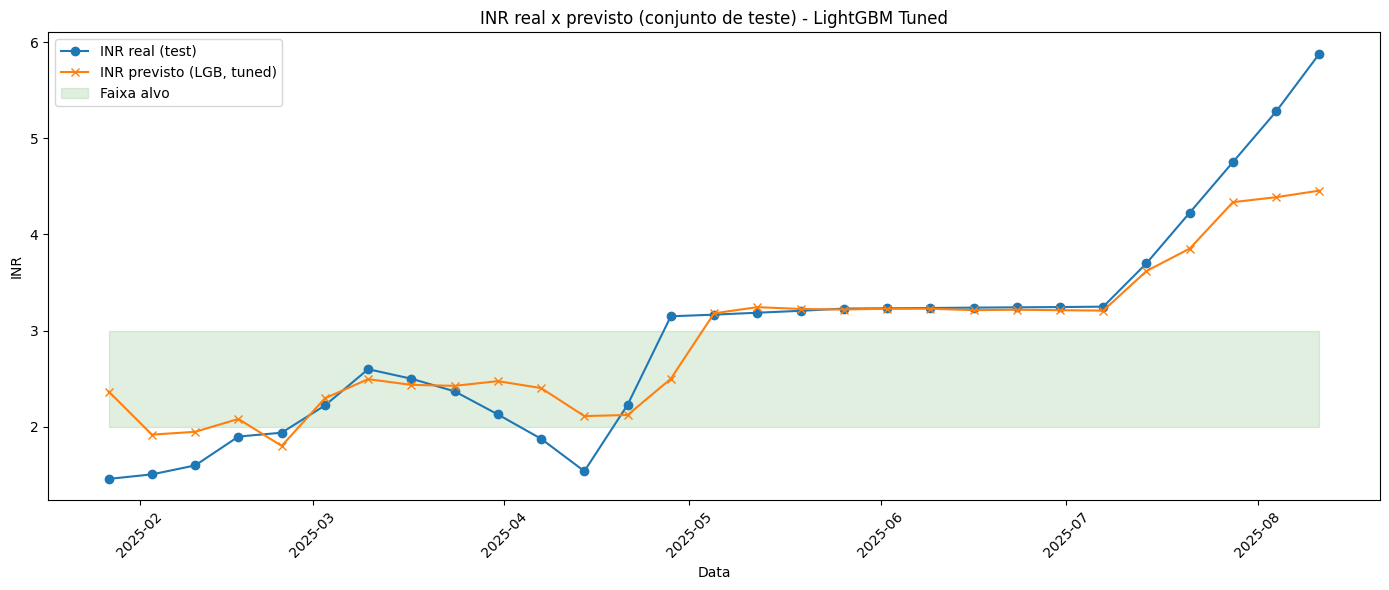

In [143]:
# Real x Previsto (test)
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test.values, label='INR real (test)', marker='o')
plt.plot(dates_test, y_pred_test, label='INR previsto (LGB, tuned)', marker='x')
plt.fill_between(dates_test, low_vals, high_vals, color='green', alpha=0.12, label='Faixa alvo')
plt.xlabel("Data")
plt.ylabel("INR")
plt.title("INR real x previsto (conjunto de teste) - LightGBM Tuned")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

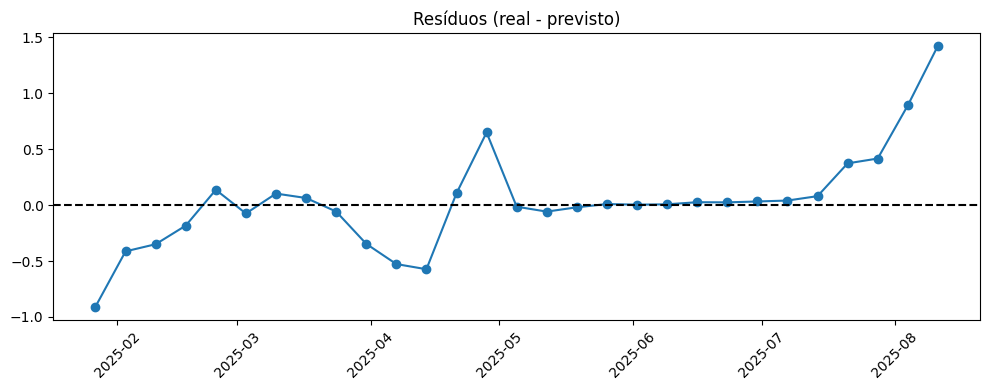

In [144]:
# Residuals
plt.figure(figsize=(10,4))
resid = y_test.values - y_pred_test
plt.plot(dates_test, resid, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.title("Resíduos (real - previsto)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

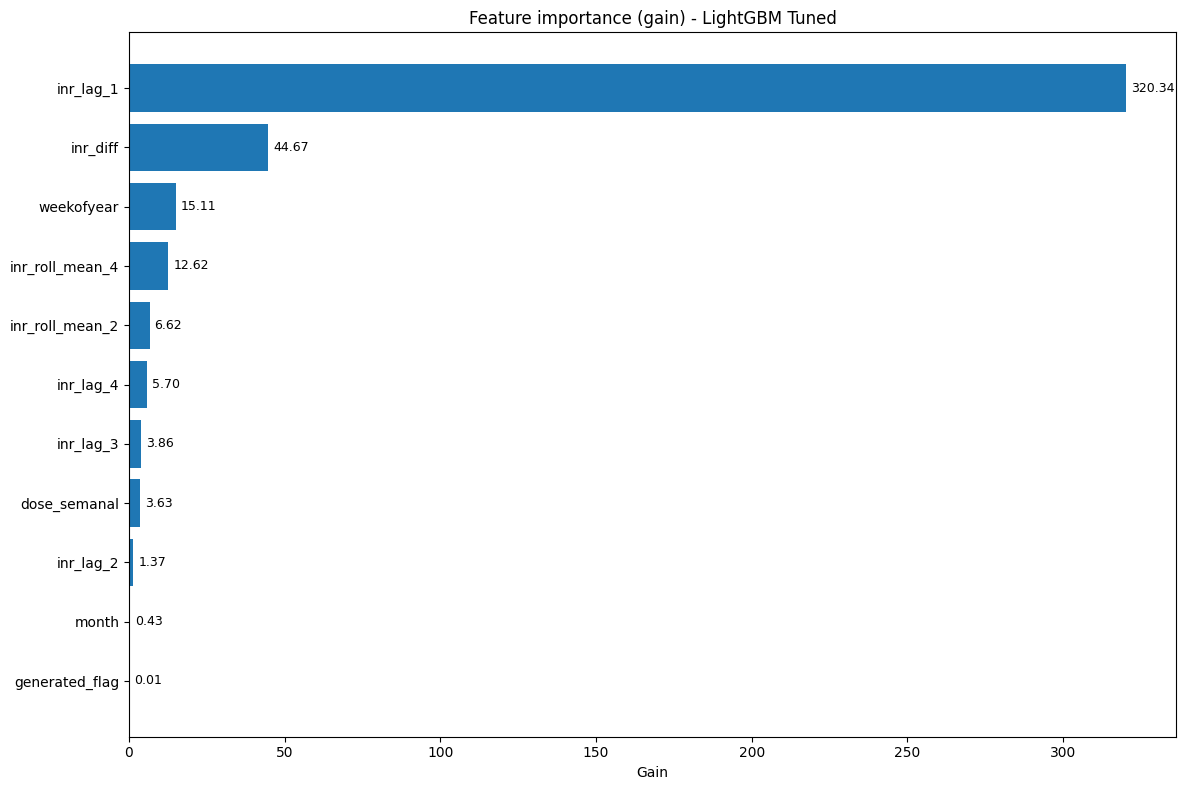

In [145]:
# Feature importance
gain = model.booster_.feature_importance(importance_type='gain')
feat_names = model.booster_.feature_name()
imp_df = pd.DataFrame({'feature': feat_names, 'gain': gain}).sort_values('gain', ascending=True).tail(30)

plt.figure(figsize=(12,8))
bars = plt.barh(imp_df['feature'], imp_df['gain'])
for bar in bars:
    w = bar.get_width()
    plt.text(w + (imp_df['gain'].max() * 0.005), bar.get_y() + bar.get_height()/2, f"{w:.2f}", va='center', fontsize=9)
plt.title("Feature importance (gain) - LightGBM Tuned")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

## 4. Treinando RandomForest

### 4.1  RandomForest com hiperparâmetros fixos

In [ ]:
RANDOM_STATE = 32

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

param_grid_rf = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [7, 12, 20, None],
    'max_features': ['sqrt', 'log2', None]
} # 4 * 4 * 3 = 48 combinações

cv_folds = 5
skf_rf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

rf_estimator = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search_rf = GridSearchCV(
    estimator=rf_estimator,
    param_grid=param_grid_rf,
    cv=skf_rf,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

print("\n" + "="*70)
print(f"Iniciando Grid Search para Random Forest ({len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['max_features'])} combinações x {cv_folds} Folds)...")
start_time = time.time()

grid_search_rf.fit(X_train_np, y_train_np)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

In [ ]:
best_rf_score = grid_search_rf.best_score_ # Acurácia média da validação cruzada
best_rf_params = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_ # Modelo melhor otimizado

print("\n" + "="*70)
print("MELHOR MODELO RANDOM FOREST OTIMIZADO")
print(f"Média Acurácia de Validação ({cv_folds} Folds): {best_rf_score:.4f}")
print("Melhores Parâmetros Encontrados:")
print(f"  - n_estimators: {best_rf_params['n_estimators']}")
print(f"  - max_depth: {best_rf_params['max_depth']}")
print(f"  - max_features: {best_rf_params['max_features']}")
print("="*70)

In [ ]:
y_pred_train = best_rf_model.predict(X_train)
y_pred_test = best_rf_model.predict(X_test)

print("\nDesempenho do Random Forest Final")
print(f"Ein (Erro treino): {1 - accuracy_score(y_train, y_pred_train):.4f}")
print(f"Eout (Erro teste): {1 - accuracy_score(y_test, y_pred_test):.4f}")
print("\nRelatório de classificação (Teste):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Matriz de Confusão - Random Forest Final")
plt.show()